![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `8` (11 Sep 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **BACKGROUND**

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
    - USTAR filerting (Level-3.3)
- Other flux levels are currently not produced in this example:
    - Gap-filling (Level-4.1)
    - NEE Partitioning (Level-4.2)
 
**Important**
- Variable names in the input files need to follow the [FLUXNET convention](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/)

</br>

# **USER SETTINGS**

## Flux variable
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O` ... Nitrous oxide flux
  - `FCH4` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

Set the name of the flux variable in the output file(s), must use the FLUXNET naming convention, e.g. FC, FH2O, LE, ET, H, FN2O, FCH4:

In [1]:
FLUXVAR = "FN2O"

## Site location
- Latitude and longitude of the site where data were recorded. This info is mainly used to calculate potential radiation, which is then used to divide the dataset into daytime and nighttime data.
- UTC offset of the timestamp used in the dataset, important for calculating potential radiation for this location with the correct timestamp.

In [2]:
SITE_LAT = 47.210227
SITE_LON = 8.410645
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime

## Daytime/nighttime
- Threshold for potential radiation in `W m-2`, records below threshold are considered nighttime

In [3]:
NIGHTTIME_THRESHOLD = 50

## Quality requirements
- The new default setting is to only accept highest-quality fluxes where the overall quality flag `QCF` = 0
- This strict quality-filtering removes a lot of data points, but running random forest gap-filling with only the highest-quality records yields far better model results in terms of scoring (higher r2, lower error)

In [4]:
DAYTIME_ACCEPT_QCF_BELOW = 1
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 1

## Source data
- It is possible to load data from (multiple) EddyPro _fluxnet_ output files (data from files will be merged), or directly from one single [parquet](https://parquet.apache.org/) file.
- parquet files are a good option for large datasets because they load and save much faster than when using conventional CSV files.
- For large datasets, it makes sense to first load and merge data from the original EddyPro _fluxnet_ output files, then convert the merged data to one single parquet file and then use this file as input file.

If you want to search for EddyPro _fluxnet_ files in specific locations, you can specify multiple folders here:

In [5]:
SOURCEDIRS = [
    r'L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\cha_fp2024.1_2005-2023\0_data\RESULTS-IRGA-Level-1_fluxnet_2005-2023'
]  # Folders where input file(s) are located

If you want to load data directly from a specific parquet file, you can specify its name and location here:

In [6]:
SOURCEDIR = r"L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\40_FLUXES_L1_IRGA+QCL+LGR_mergeData"
FILENAME = r"41.1_CH-CHA_IRGA_LGR+QCL_Level-1_eddypro_fluxnet_2005-2023_meteo7.parquet"
from pathlib import Path

FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")

Data will be loaded from the following file:
L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\40_FLUXES_L1_IRGA+QCL+LGR_mergeData\41.1_CH-CHA_IRGA_LGR+QCL_Level-1_eddypro_fluxnet_2005-2023_meteo7.parquet


</br>

# **IMPORTS**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [7]:
import scipy.stats
import importlib.metadata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.82.0


</br>

# **DOCSTRING** for `FluxProcessingChain`

In [8]:
help(FluxProcessingChain)

Help on class FluxProcessingChain in module diive.pkgs.fluxprocessingchain.fluxprocessingchain:

class FluxProcessingChain(builtins.object)
 |  FluxProcessingChain(maindf: pandas.core.frame.DataFrame, fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, nighttime_threshold: float = 50)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, maindf: pandas.core.frame.DataFrame, fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, nighttime_threshold: float = 50)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  analyze_highest_quality_flux(self, showplot: bool = True)
 |  
 |  finalize_level2(self, nighttime_threshold: int = 50, daytime_accept_qcf_below: int = 2, nighttimetime_accept_qcf_below: int = 2)
 |      Calculate overall quality flag QCF after Level-2
 |  
 |  finalize_level31(self)
 |  
 |  finalize_level32(self, nighttime_threshold: int = 50, daytime_accept_qcf_below: int = 2, nighttimetime_accept_qcf_below: int = 2)
 |     

</br>

</br>

# **LOAD DATA** (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

In [9]:
# ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype=FILETYPE)

In [10]:
# ep.searchfiles()

In [11]:
# ep.loadfiles()

In [12]:
# maindf = ep.maindf
# metadata = ep.metadata

</br>

## Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [13]:
maindf = load_parquet(filepath=FILEPATH)

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\40_FLUXES_L1_IRGA+QCL+LGR_mergeData\41.1_CH-CHA_IRGA_LGR+QCL_Level-1_eddypro_fluxnet_2005-2023_meteo7.parquet (2.494 seconds). Detected time resolution of <30 * Minutes> / 30min 


In [14]:
# Use one year of data
maindf = maindf.loc[maindf.index.year >= 2021].copy()
# maindf = maindf.loc[(maindf.index.year == 2017) | (maindf.index.year == 2018)].copy()
# maindf = maindf.loc[(maindf.index.month >= 5) & (maindf.index.month <= 6)].copy()

</br>

## Check data

In [15]:
maindf

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD      BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_HEIGHT_SA  BADM_SA_OFFSET_NORTH  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_H2O  BADM_INSTPAIR_EASTWARD_SEP_GA_H2O  BADM_INSTPAIR_HEIGHT_SEP_GA_H2O  CUSTOM_FILTER_NR   CO2_NR  CO2_MEAS_TYPE  ...  N2O_MEAS_P25  N2O_MEAS_P75  N2O_MEAS_SIGMA  N2O_MEAS_SKW  N2O_MEAS_TYPE  N2O_MIXING_RATIO  N2O_MOLAR_DENSITY   N2O_NR  N2O_NUM_SPIKES  N2O_SPIKE_NREX  N2O_TLAG_ACTUAL  N2O_TLAG_MAX  N2O_TLAG_MIN  N2O_TLAG_NOMINAL  N2O_TLAG_USED  N2O_VM97_TEST  N2O_ZCD  RESPONSE_TIME_GA_CH4  RESPONSE_TIME_GA_N2O  SCH4_SINGLE  SN2O_SINGLE  VPATH_GA_CH4  VPATH_GA_N2O  W_CH4_MEAS_COV  W_N2O_MEAS_COV
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ...                                                                                                                                                                                                                                                                                                                                                                                               
2021-01-01 00:15:00  0.023716      1.21833     1228.85  1008.63         0.0                   1.0        NaN           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                 NaN                                NaN                              NaN           36000.0  36000.0            2.0  ...      0.322827      0.323726        0.000681      0.571938            0.0           323.318           0.000581  36000.0             0.0             0.0              0.6           0.9           0.4               0.6            0.6    800000011.0  18073.0                0.1308                0.1308     6.227180     0.035176          32.0          32.0       -0.000551        0.000007
2021-01-01 00:45:00  0.023712      1.21856     1229.06  1008.62         0.0                   1.0  -0.253403           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                14.0                               31.0                              1.0           36000.0  35989.0            2.0  ...      0.322668      0.323256        0.000493      0.805679            0.0           322.993           0.000580  35989.0             0.0             0.0              0.6           0.9           0.4               0.6            0.6    800000011.0  18037.0                0.1308                0.1308    -1.300030    -0.016753          32.0          32.0       -0.000263        0.000002
2021-01-01 01:15:00  0.023706      1.21884     1229.36  1008.63         0.0                   1.0  22.441900           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                

In [16]:
sstats(maindf[FLUXVAR])

FN2O
STARTDATE       2021-01-01 00:15
ENDDATE         2023-12-31 23:45
PERIOD        1094 days 23:30:00
NOV                        25956
MISSING                    26604
MISSING_PERC           50.616438
MEAN                    0.591538
MEDIAN                  0.171814
SD                       4.29959
VAR                    18.486474
SD/MEAN                 7.268499
SUM                 15353.948212
MIN                     -306.444
MAX                      169.591
P01                    -4.744791
P05                    -0.914515
P25                     -0.04492
P75                     0.606153
P95                     4.090732
P99                    10.540495

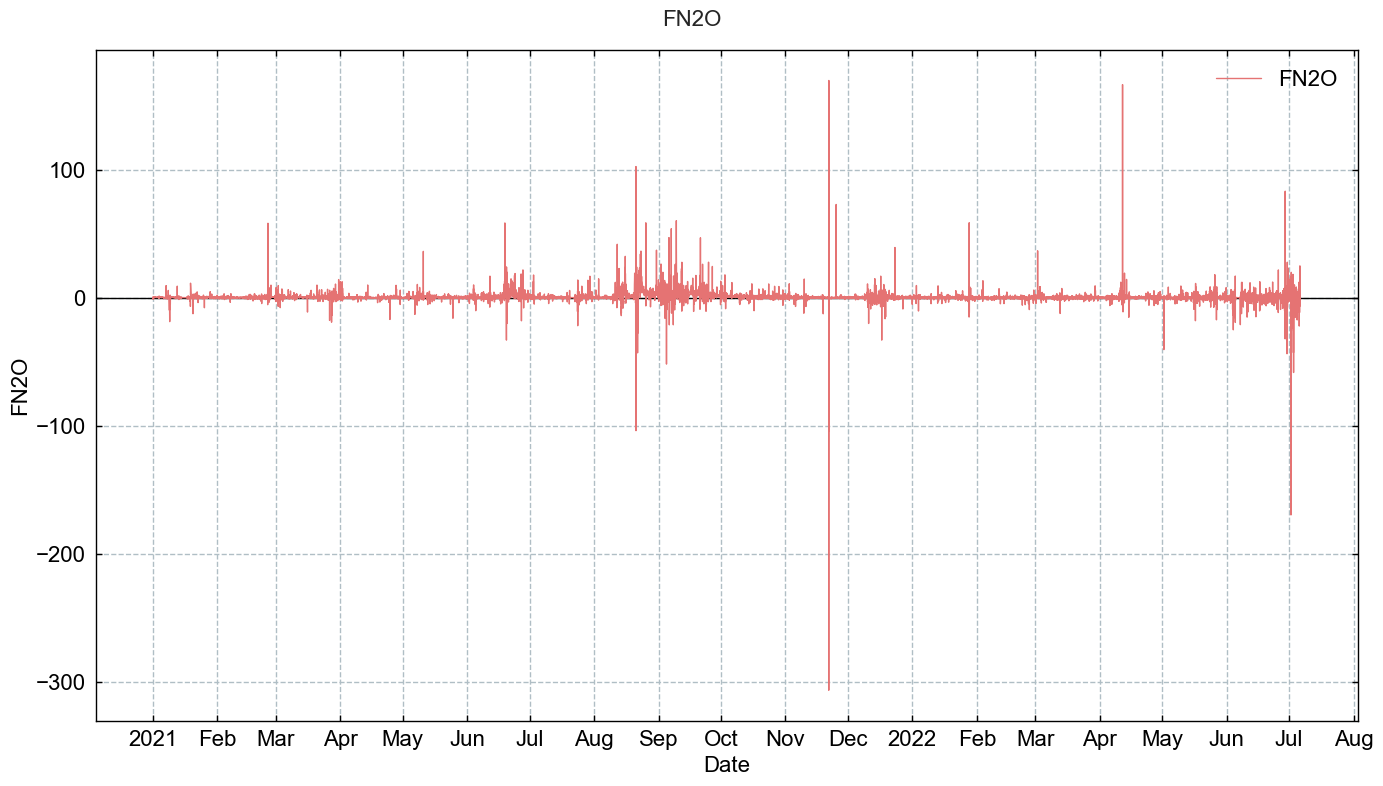

In [17]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

# **START FLUX PROCESSING CHAIN**

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [18]:
fpc = FluxProcessingChain(
    maindf=maindf,
    fluxcol=FLUXVAR,
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET
)

Detected base variable N2O for FN2O. (N2O was used to calculate FN2O.)
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [19]:
fpc.fpc_df

FN2O     USTAR  SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                                      
2021-01-01 00:15:00  0.313659  0.060506        0.0      0.0        1.0
2021-01-01 00:45:00  0.111344  0.083723        0.0      0.0        1.0
2021-01-01 01:15:00  0.226367  0.071258        0.0      0.0        1.0
2021-01-01 01:45:00  0.145882  0.089855        0.0      0.0        1.0
2021-01-01 02:15:00 -1.211530  0.176293        0.0      0.0        1.0
...                       ...       ...        ...      ...        ...
2023-12-31 21:45:00       NaN  0.114945        0.0      0.0        1.0
2023-12-31 22:15:00       NaN  0.154797        0.0      0.0        1.0
2023-12-31 22:45:00       NaN  0.183323        0.0      0.0        1.0
2023-12-31 23:15:00       NaN  0.201075        0.0      0.0        1.0
2023-12-31 23:45:00       NaN  0.184102        0.0      0.0        1.0

[52560 rows x 5 columns]

</br>

</br>

---

# Level-2: **QUALITY FLAG EXTENSION**

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004:
    - `0` for best quality fluxes
    - `1` for fluxes suitable for general analysis such as annual budgets (although this is debatable)
    - `2` for fluxes that should be discarded from the dataset

In [20]:
TEST_SSITC = True  # Default True

</br>

### Flux base variable completeness test (default: `True`)
- Flag newly calculated here
- Check completeness of the variable that was used to calculate the respective flux
- Example: `CO2` is the base variable that was used to calculate flux `FC`, the test is therefore run on `CO2`
- Checks number of records of the relevant base variable available for each averaging Interval and calculates completeness flag as follows:
    - `0` for files where >= 99% of base variable are available
    - `1` for files where >= 97% and < 99% of base variable are available
    - `2` for files where < 97% of base variable are available
 
List of flux base variables and the corresponding fluxes:
- `CO2`: used to calculate `FC`
- `H2O`: used to calculate `FH2O`
- `H2O`: used to calculate `LE`
- `H2O`: used to calculate `ET`
- `T_SONIC`: used to calculate `H`
- `N2O`: used to calculate `FN2O`
- `CH4`: used to calculate `FCH4`

In [21]:
TEST_GAS_COMPLETENESS = True  # Default True

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `SCF` variable in EddyPro output file

In [22]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # Default True

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration/temperature was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold

In [23]:
# Signal strength
TEST_SIGNAL_STRENGTH = False
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Typical variable name in fluxnet files
TEST_SIGNAL_STRENGTH_METHOD = 'discard above'
TEST_SIGNAL_STRENGTH_THRESHOLD = 90

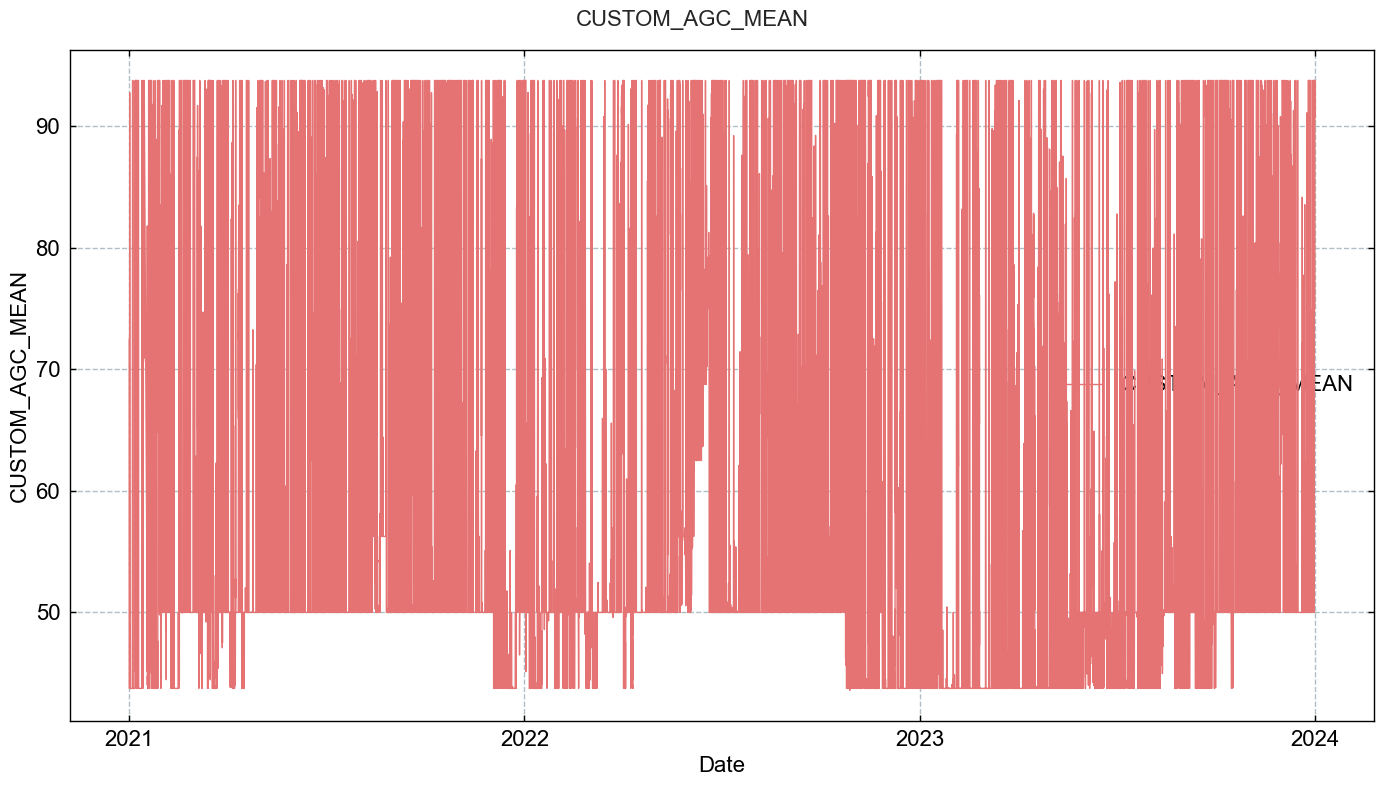

In [24]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

</br>

### Raw data screening tests
- Flags were calculated in EddyPro
- See here for more details: [Despiking and raw data statistical screening (EddyPro help)](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html)

In [25]:
TEST_RAWDATA = True  # Default True
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = False  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro
- Flag can be useful during some time periods when the sonic anemometer had issues
- Not used by default (similar to ICOS)

In [26]:
TEST_RAWDATA_ANGLE_OF_ATTACK = True  # Default False
TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = [['2008-01-01', '2010-01-01'],
                                                  ['2016-03-01', '2016-05-01']]  # Default False

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [27]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [28]:
LEVEL2_SETTINGS = {
    'signal_strength': {
        'apply': TEST_SIGNAL_STRENGTH,
        'signal_strength_col': TEST_SIGNAL_STRENGTH_COL,
        'method': TEST_SIGNAL_STRENGTH_METHOD,
        'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {
        'apply': TEST_RAWDATA,
        'spikes': TEST_RAWDATA_SPIKES,
        'amplitude': TEST_RAWDATA_AMPLITUDE,
        'dropout': TEST_RAWDATA_DROPOUT,
        'abslim': TEST_RAWDATA_ABSLIM,
        'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF,
        'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF,
        'discont_hf': TEST_RAWDATA_DISCONT_HF,
        'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': {
        'apply': TEST_SSITC},
    'gas_completeness': {
        'apply': TEST_GAS_COMPLETENESS},
    'spectral_correction_factor': {
        'apply': TEST_SPECTRAL_CORRECTION_FACTOR},
    'angle_of_attack': {
        'apply': TEST_RAWDATA_ANGLE_OF_ATTACK,
        'application_dates': TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES},
    'steadiness_of_horizontal_wind': {
        'apply': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND}
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)

[MissingValues]  running MissingValues ...
SSITC TEST: Generated new flag variable FLAG_L2_FN2O_SSITC_TEST, values taken from output variable FN2O_SSITC_TEST ...
FLUX BASE VARIABLE COMPLETENESS TEST: Generated new flag variable FLAG_L2_FN2O_COMPLETENESS_TEST, newly calculated from variable N2O, with flag 0 (good values) where available number of records for N2O >= 0.99, flag 1 (ok values) >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FN2O_SCF_TEST, newly calculated from output variable FN2O_SCF, withflag 0 (good values) where FN2O_SCF < 2, flag 1 (ok values) where FN2O_SCF >= 2 and < 4, flag 2 (bad values) where FN2O_SCF >= 4...
RAW DATA TEST: Generated new flag variable FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST, values taken from output variable N2O_VM97_TEST from position 1, based on N2O, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where te

</br>

</br>

## **Finalize Level-2**

In [29]:
fpc.finalize_level2(nighttime_threshold=NIGHTTIME_THRESHOLD, daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
                    nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW)

++Added new column FLAG_L2_FN2O_MISSING_TEST.
++Added new column FLAG_L2_FN2O_SSITC_TEST.
++Added new column FLAG_L2_FN2O_COMPLETENESS_TEST.
++Added new column FLAG_L2_FN2O_SCF_TEST.
++Added new column FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST.
++Added new column FLAG_L2_FN2O_VM97_AOA_HF_TEST.
++Added new column SUM_L2_FN2O_HARDFLAGS.
++Added new column SUM_L2_FN2O_SOFTFLAGS.
++Added new column SUM_L2_FN2O_FLAGS.
++Added new column FLAG_L2_FN2O_QCF.
++Added new column FN2O_L2_QCF.
++Added new column FN2O_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [30]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FN2O_MISSING_TEST',
 'FLAG_L2_FN2O_SSITC_TEST',
 'FLAG_L2_FN2O_COMPLETENESS_TEST',
 'FLAG_L2_FN2O_SCF_TEST',
 'FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST',
 'FLAG_L2_FN2O_VM97_AOA_HF_TEST',
 'SUM_L2_FN2O_HARDFLAGS',
 'SUM_L2_FN2O_SOFTFLAGS',
 'SUM_L2_FN2O_FLAGS',
 'FLAG_L2_FN2O_QCF',
 'FN2O_L2_QCF',
 'FN2O_L2_QCF0']

</br>

### Plots

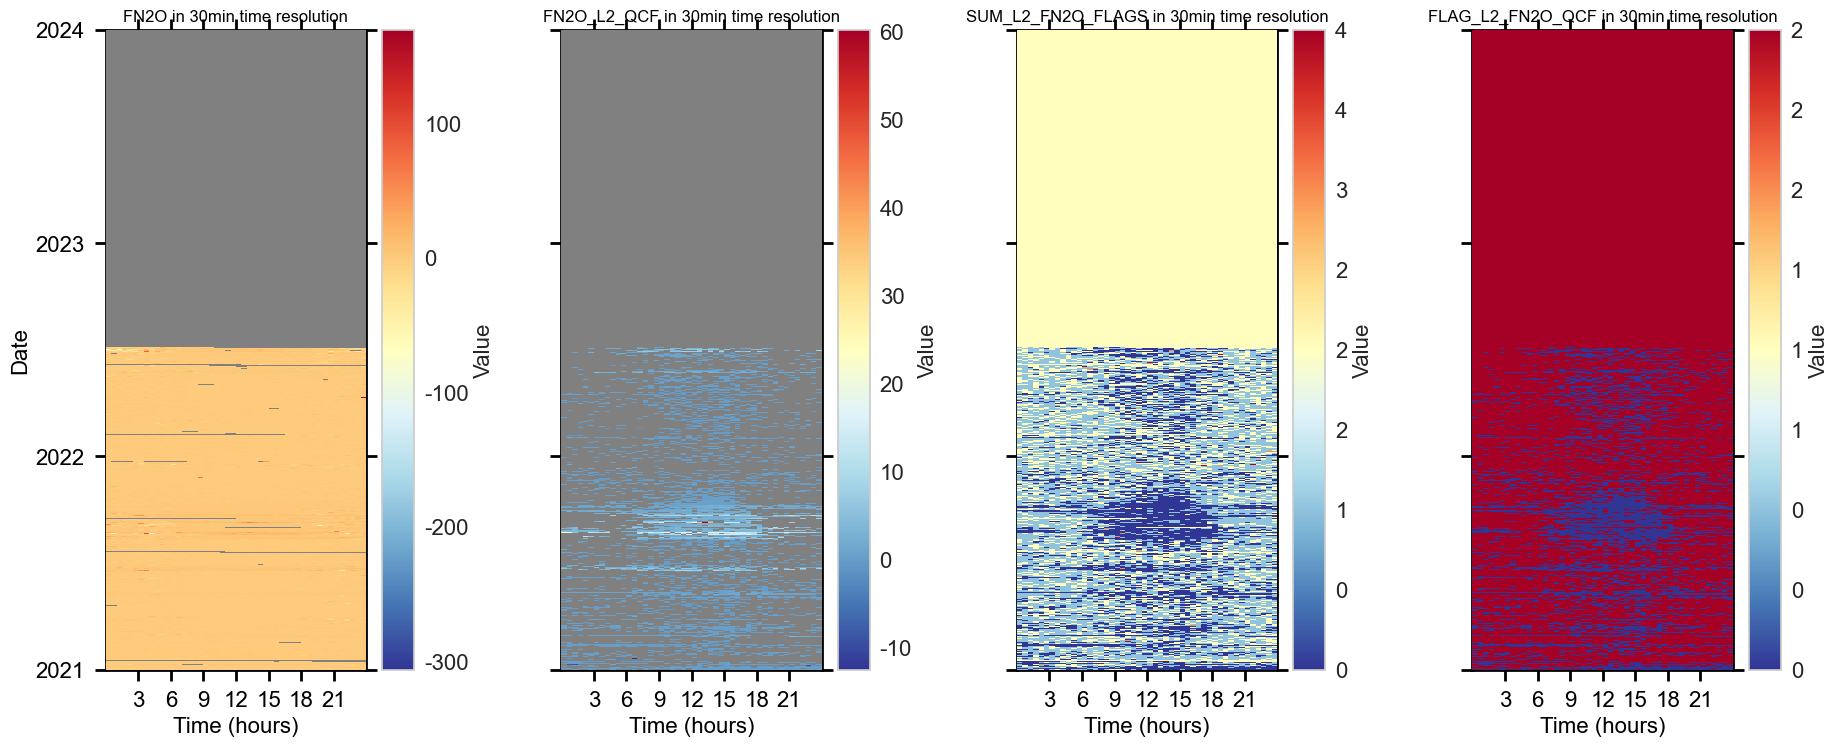

In [31]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [32]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [33]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FN2O.

Number of FN2O records before QC: 25956
+++ FLAG_L2_FN2O_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 25956 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_SSITC_TEST rejected 18866 values (+72.68%)      TOTALS: flag 0: 7090 (27.32%) / flag 1: 0 (0.00%) / flag 2: 18866 (72.68%)
+++ FLAG_L2_FN2O_COMPLETENESS_TEST rejected 10 values (+0.04%)      TOTALS: flag 0: 7080 (27.28%) / flag 1: 0 (0.00%) / flag 2: 18876 (72.72%)
+++ FLAG_L2_FN2O_SCF_TEST rejected 2 values (+0.01%)      TOTALS: flag 0: 7078 (27.27%) / flag 1: 0 (0.00%) / flag 2: 18878 (72.73%)
+++ FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 7078 (27.27%) / flag 1: 0 (0.00%) / flag 2: 18878 (72.73%)
+++ FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 7078 (27.27%) / flag 1: 0 (

In [34]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FN2O_QCF, QCF FLAG FOR FN2O
Between 2021-01-01 00:15 and 2023-12-31 23:45 ...
    Total flux records BEFORE quality checks: 25956 (49.38% of potential)
    Available flux records AFTER quality checks: 7078 (27.27% of total)
    Rejected flux records: 18878 (72.73% of total)
    Potential flux records: 52560
    Potential flux records missed: 26604 (50.62% of potential)



In [35]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# Level-3.1: **STORAGE CORRECTION**

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using random forest
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [36]:
fpc.level31_storage_correction(gapfill_storage_term=True)

Detected storage variable SN2O_SINGLE for FN2O.
Calculating storage-corrected flux FN2O_L3.1 from flux FN2O and storage term SN2O_SINGLE ...

Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 52560.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2021-01-01 00:15:00 and 2023-12-31 23:45:00 ...

Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomFo

</br>

## **Finalize Level-3.1**

In [37]:
fpc.finalize_level31()

++Added new column SN2O_SINGLE.
++Added new column SN2O_SINGLE_gfRF_L3.1.
++Added new column FLAG_SN2O_SINGLE_gfRF_ISFILLED_L3.1.
++Added new column FN2O_L3.1.
++Added new column FN2O_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column FN2O_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [38]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['SN2O_SINGLE_gfRF_L3.1',
 'FLAG_SN2O_SINGLE_gfRF_ISFILLED_L3.1',
 'FN2O_L3.1',
 'FN2O_L3.1_QCF',
 'FN2O_L3.1_QCF0']

</br>

### Plots

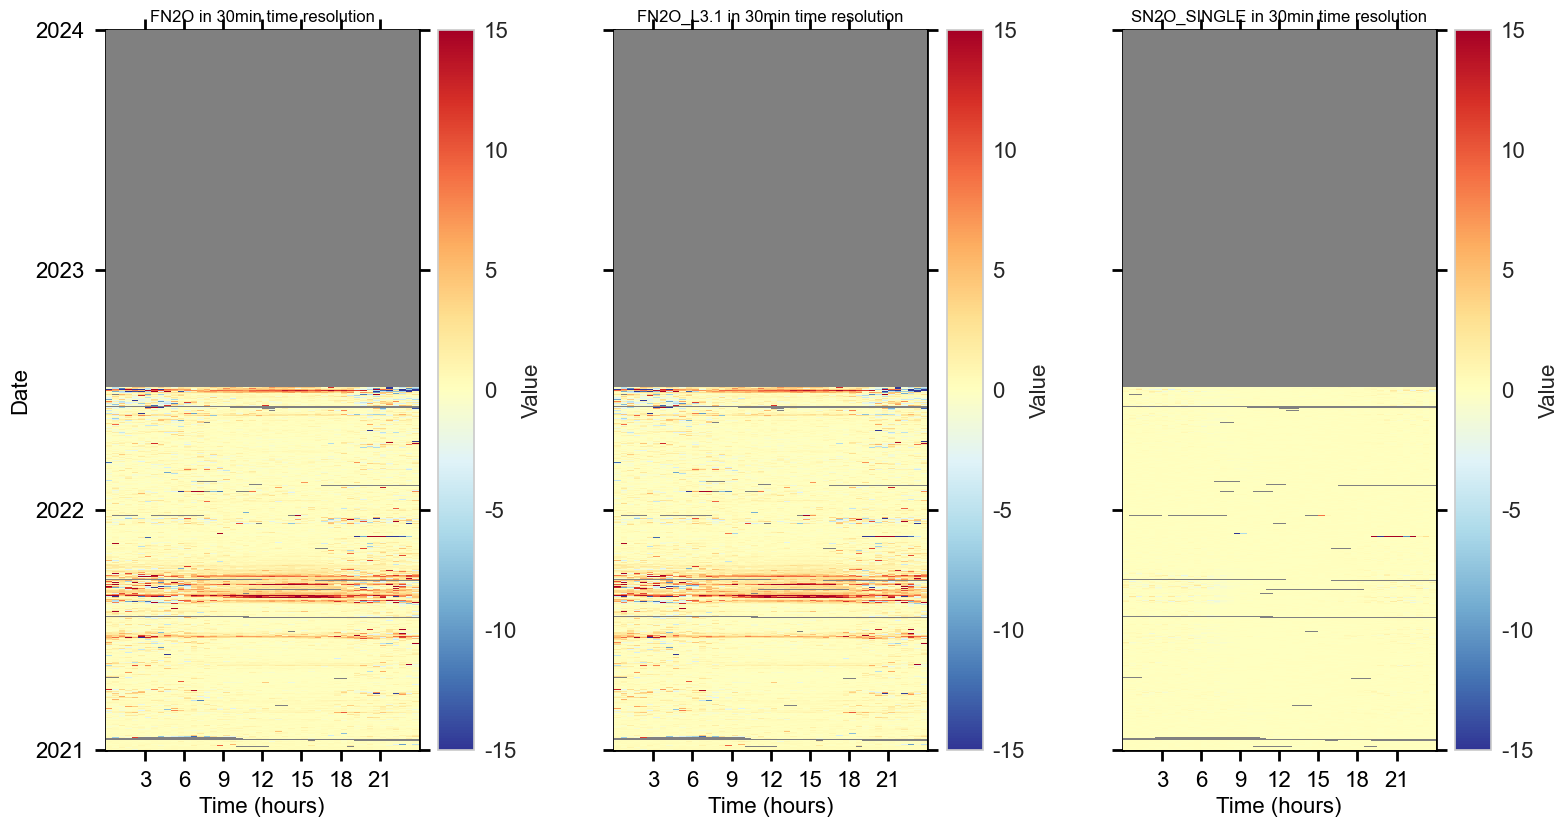

In [39]:
fpc.level31.showplot(maxflux=15)

</br>

### Report

In [47]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FN2O
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term SN2O_SINGLE_gfRF_L3.1 was added to flux FN2O.
The storage-corrected flux was stored as FN2O_L3.1.

The flux was available for 25956 records (FN2O).
The original, non-gapfilled storage term was available for 25917 records (SN2O_SINGLE).
This means that the storage term SN2O_SINGLE is missing for 39 measured flux (FN2O) records.
Without gap-filling the storage term SN2O_SINGLE, 39 measured flux records (FN2O) are lost.

For this run, gap-filling of SN2O_SINGLE was * SELECTED *.
After gap-filling the storage term, it was available for an additional 39 records (SN2O_SINGLE_gfRF_L3.1).

In the storage-corrected flux FN2O_L3.1 with 25956 records, 
  - 99.8% (25917 records) of used storage terms come from originally calculated data (SN2O_SINGLE)
  - 0.2% (39 records) of used storage terms come from gap-filled data (SN2O_SINGLE_gfRF_L3.1)

Stats for gap-filled storage ter

</br>

---    

# Optional: **Analyze highest-quality flux** (so far)
- Analysis of fluxes after Level-3.1 where the overall quality flag `QCF` = 0
- This helps in understanding in what range the "true" flux occurs
- Here, the highest-quality fluxes are additionally filtered for outlier values using the relatively fast Local Outlier Factor test
- For this quick analysis, it is possible that the outlier test cuts off some "real" values that should be retained, but it nevertheless helps in understanding the flux range
- `QCF` = 0 is best quality, `QCF` = medium quality, `QCF` = 2 bad quality and always rejected
- The difference between quality 0 and quality 1 or 2 is huge

>>> Removing outliers from highest-quality DAYTIME fluxes (FN2O_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=47, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 32 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 DAYTIME:   19.7379198
>>> Smallest non-outlier flux >= 0 DAYTIME:  0.0009709000000000002
>>> Largest non-outlier flux < 0 DAYTIME:    -0.0004364999999999994
>>> Smallest non-outlier flux < 0 DAYTIME:   -0.6410473999999999
>>> Removing outliers from highest-quality NIGHTTIME fluxes (FN2O_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=23, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 20 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 NIGHTTIME:   12.5765162
>>> Smallest non-outlier flux >= 0 NIG

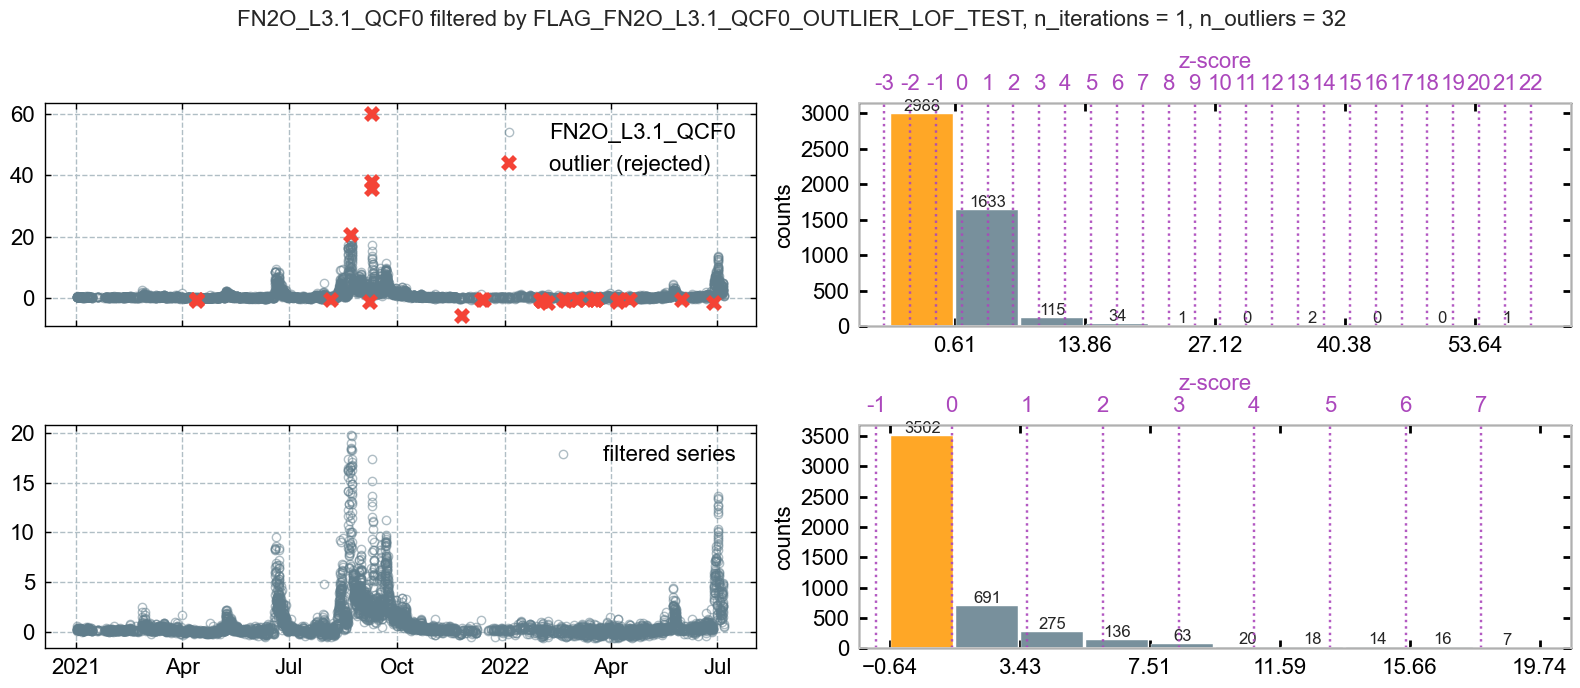

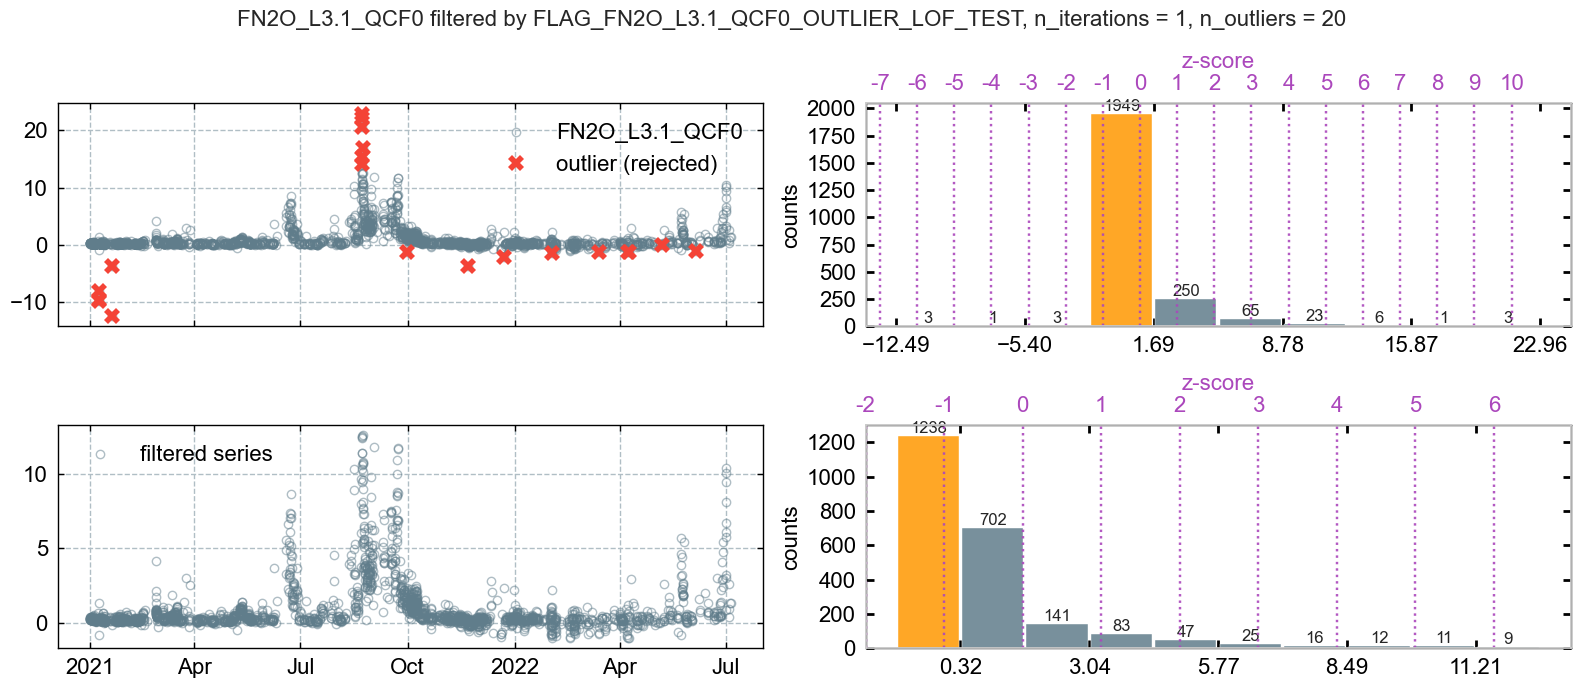

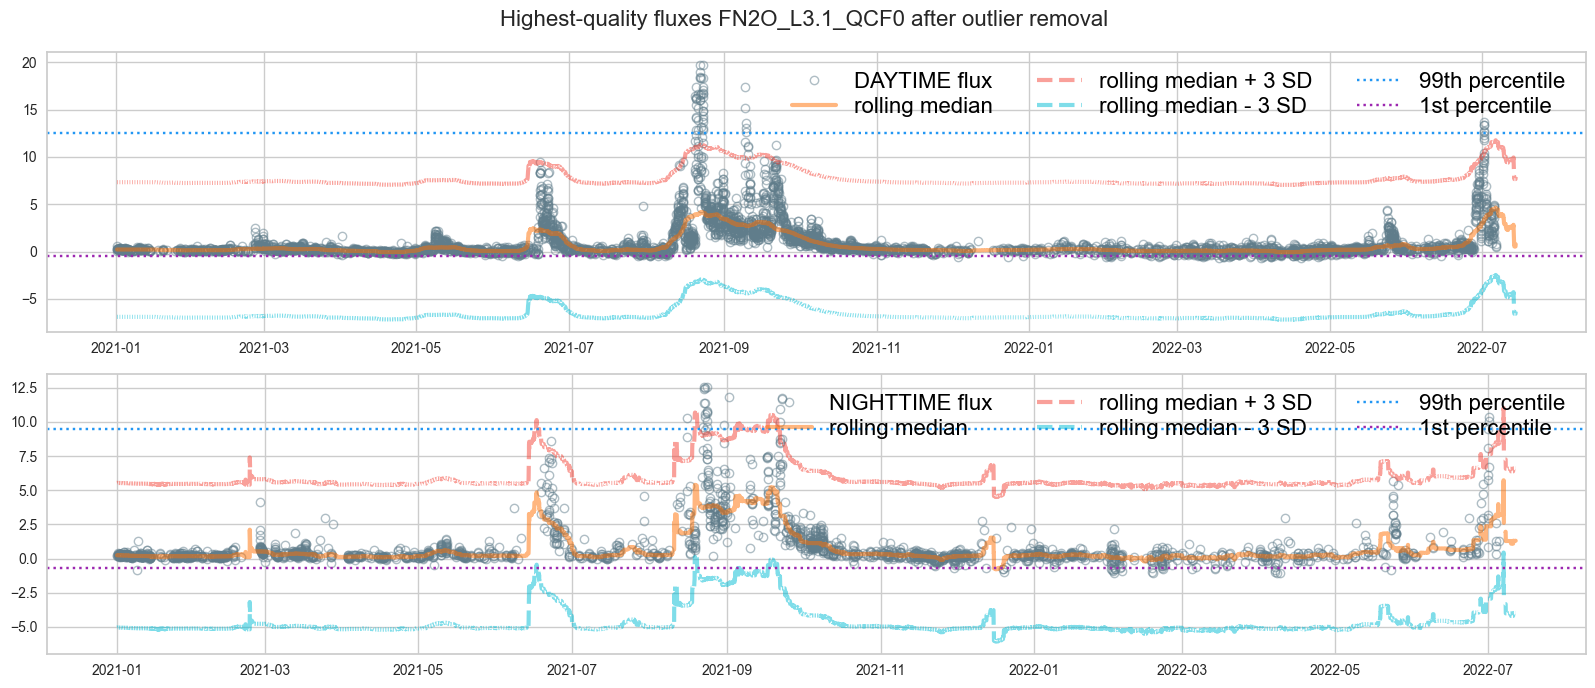

In [48]:
analyze_highest_quality_flux(flux=fpc.fpc_df[fpc.filteredseries_hq.name], nighttime_flag=fpc.fpc_df['NIGHTTIME'])

---

</br>

# Level-3.2: **OUTLIER DETECTION**
- Running an outlier test creates a *preview* plot of the results
- If the output looks as desired, run `fpc.level32_addflag()` cell below the preview to accept the results you see in the plot
- All subsequent tests will then be based on these results
- This means that each test is run on the data already filtered by the previous test
- Each test creates its own quality flag
- At the end of Level-3.2, an overall quality flag `QCF` is created that combines all of the individual flags into one single flag

</br>

## Plot time series

In [49]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

FN2O_L3.1_QCF 
(quality-controlled Level-3.1 version of FN2O)


In [53]:
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [54]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Outlier flag: **Absolute limits**

In [52]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
# help(AbsoluteLimits)

[AbsoluteLimits]  running AbsoluteLimits ...


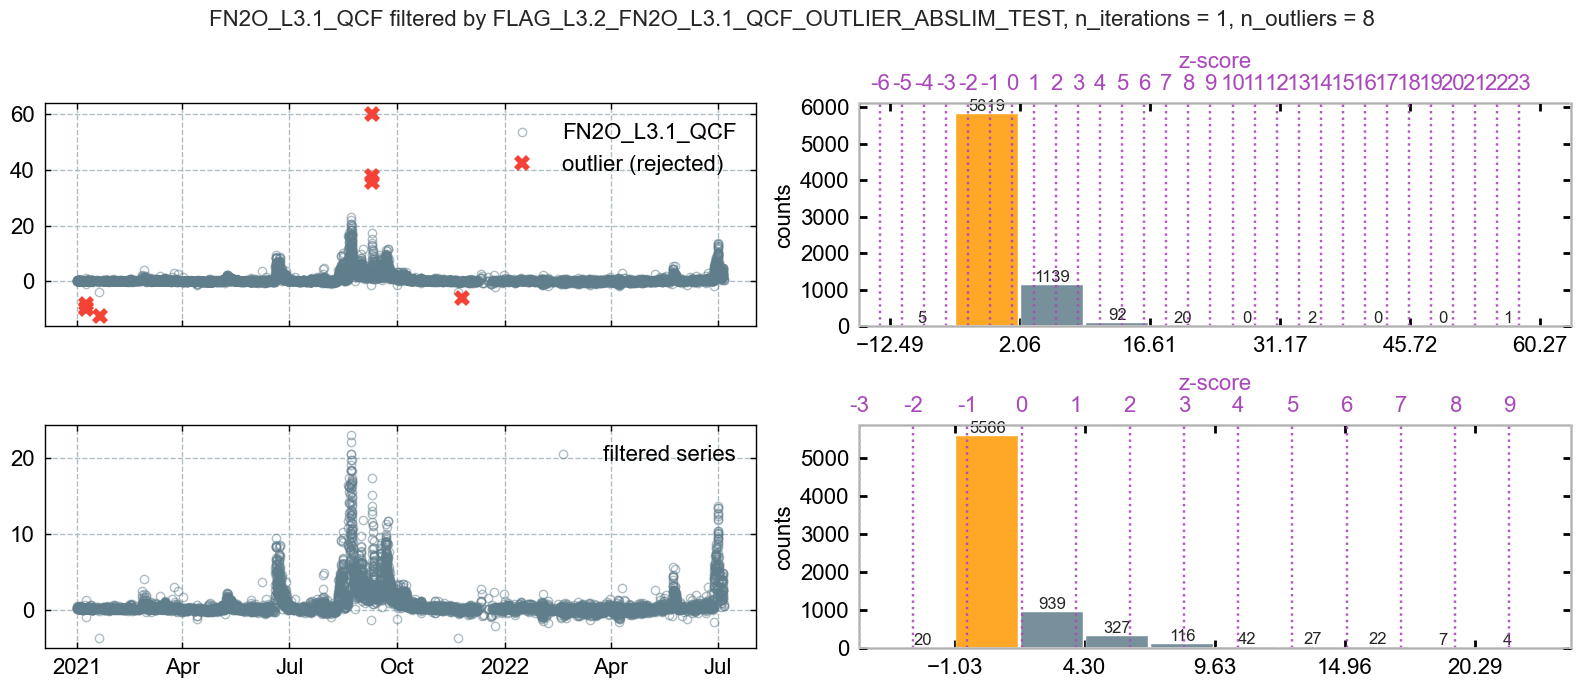

In [56]:
MIN = -4
MAX = 30
fpc.level32_flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [57]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Outlier flag: **Manual flag**
- The interactive plot can be used to determine the exact start and end of time ranges or data points that need to be removed, e.g. due to known instrument failure

In [ ]:
# from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
# help(ManualRemoval)

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False

In [ ]:
# fpc.level32_flag_manualremoval_test(
#     remove_dates=[
#         ['2016-03-18 12:15:00', '2016-05-03 06:45:00'],  # Removes date range between two datetimes (inclusive)
#         # '2023-12-12 12:45:00'  # Removes data point with specific timestamp
#     ],
#     showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False

</br>

</br>

## Outlier flag: **Hampel filter**, separate for daytime and nighttime
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 43 seconds on a fast desktop computer

In [ ]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

In [59]:
# %%time
# WINDOW_LENGTH = 48 * 3
# N_SIGMA_DT = 3.5
# N_SIGMA_NT = 3.5
# fpc.level32_flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT,
#                                            showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **z-score across all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScore
# help(zScore)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Hampel filter**
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 33 seconds on a fast desktop computer
    - tested with 19 years of 30MIN time resolution data and it needed approx. 20 minutes on a fast desktop computer

In [ ]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

[Hampel]  running Hampel ...
ITERATION#1: Total found outliers: 13 values
ITERATION#2: Total found outliers: 0 values
CPU times: total: 2.59 s
Wall time: 4.84 s


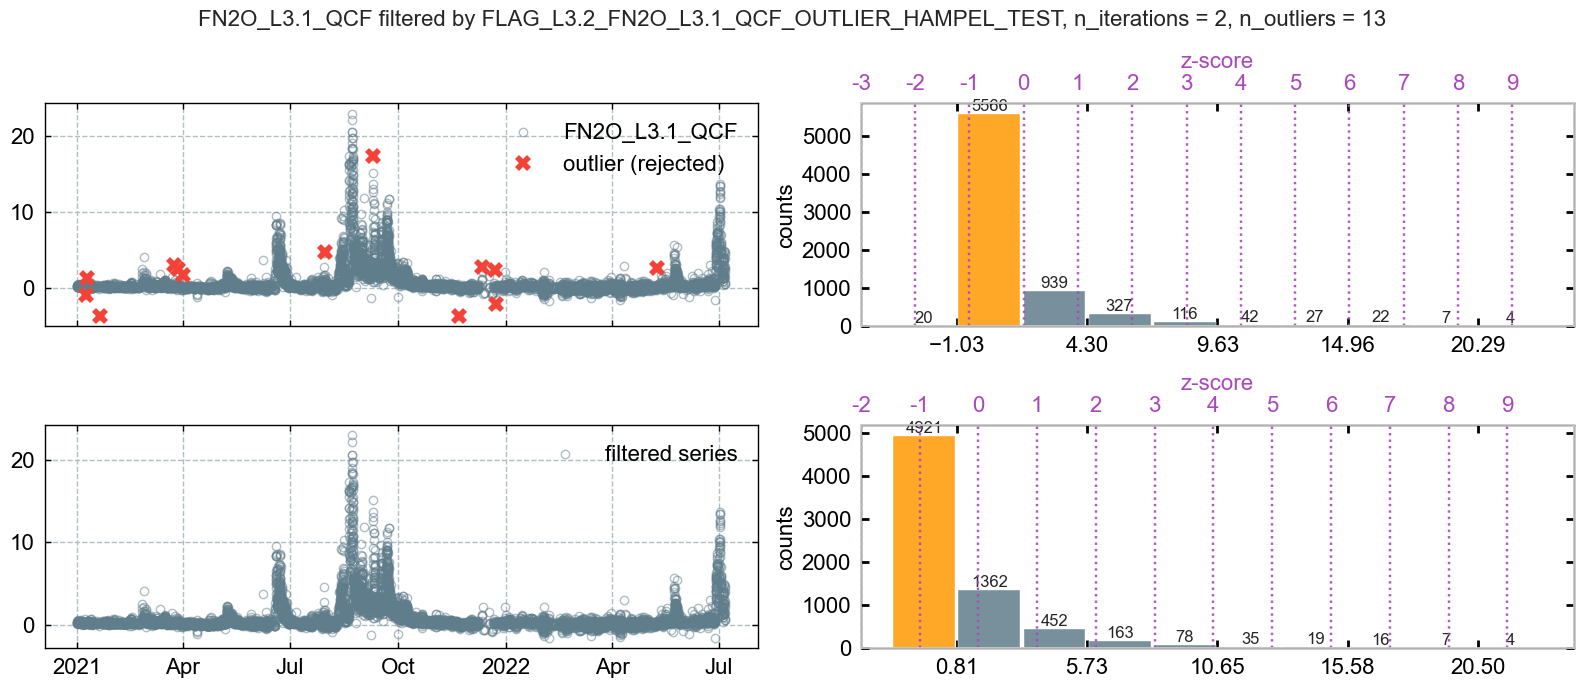

In [81]:
%%time
WINDOW_LENGTH = 48 * 5
N_SIGMA = 12
fpc.level32_flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=True)

In [82]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_HAMPEL_TEST to flag data


</br>

</br>

## Outlier flag: **z-score over all data**, separate for daytime and nighttime

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
# help(zScoreDaytimeNighttime)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Rolling z-score over all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreRolling
# help(zScoreRolling)

In [ ]:
# THRES_ZSCORE = 5.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_zscore_rolling_test(winsize=WINSIZE, thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *rolling* standard deviation

In [ ]:
# from diive.pkgs.outlierdetection.localsd import LocalSD
# help(LocalSD)

In [ ]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

[LocalSD]  running LocalSD ...
ITERATION#1: Total found outliers: 41 values
ITERATION#2: Total found outliers: 23 values
ITERATION#3: Total found outliers: 9 values
ITERATION#4: Total found outliers: 4 values
ITERATION#5: Total found outliers: 2 values
ITERATION#6: Total found outliers: 0 values


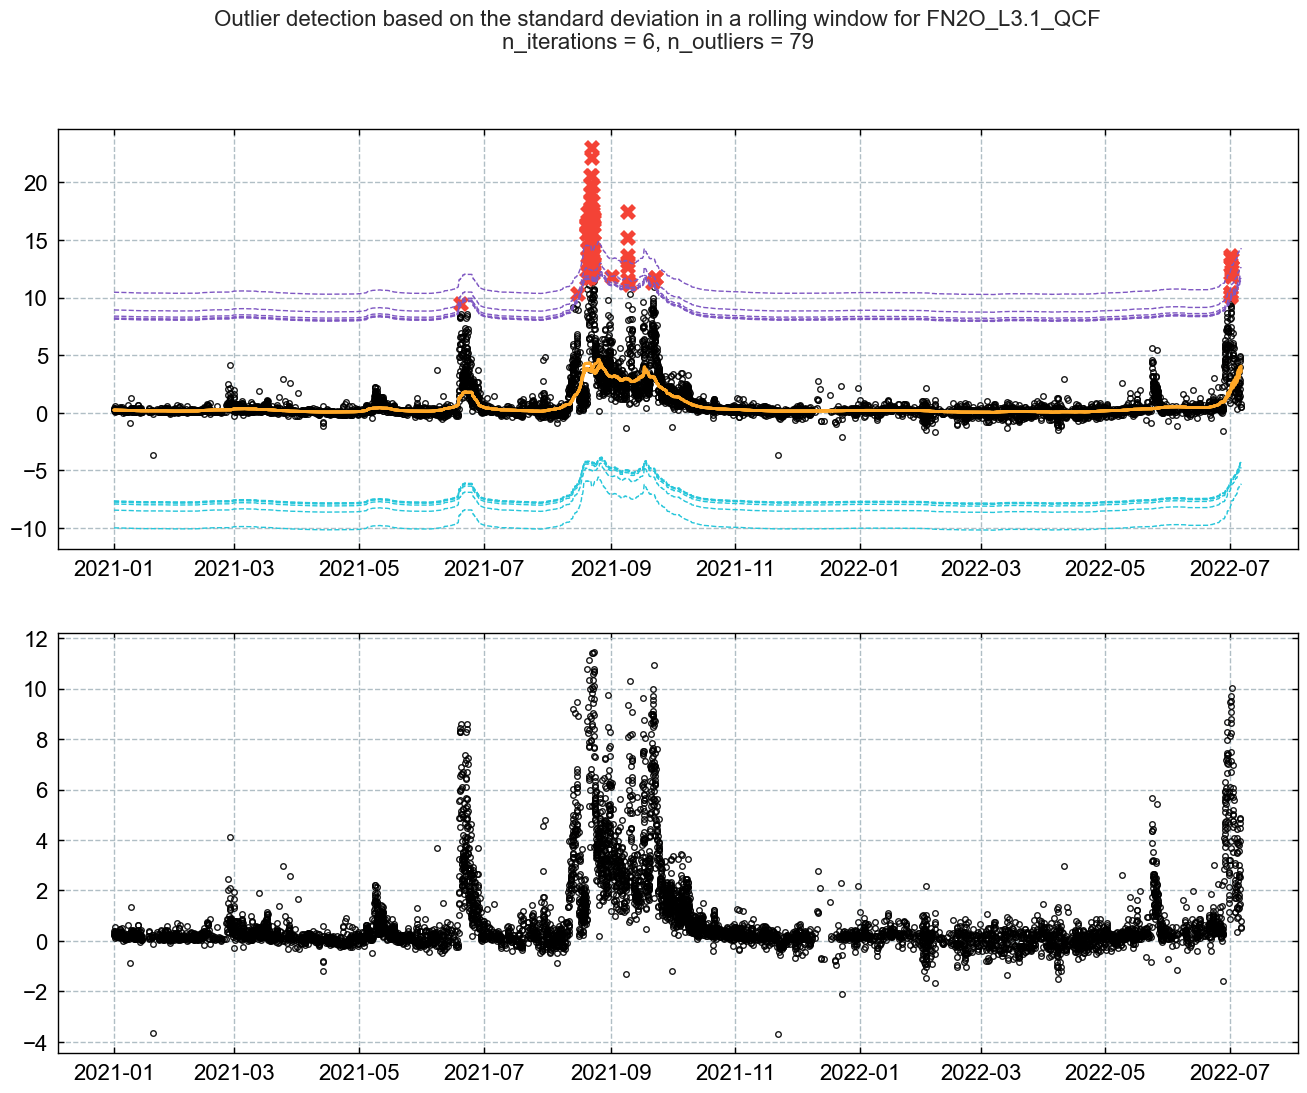

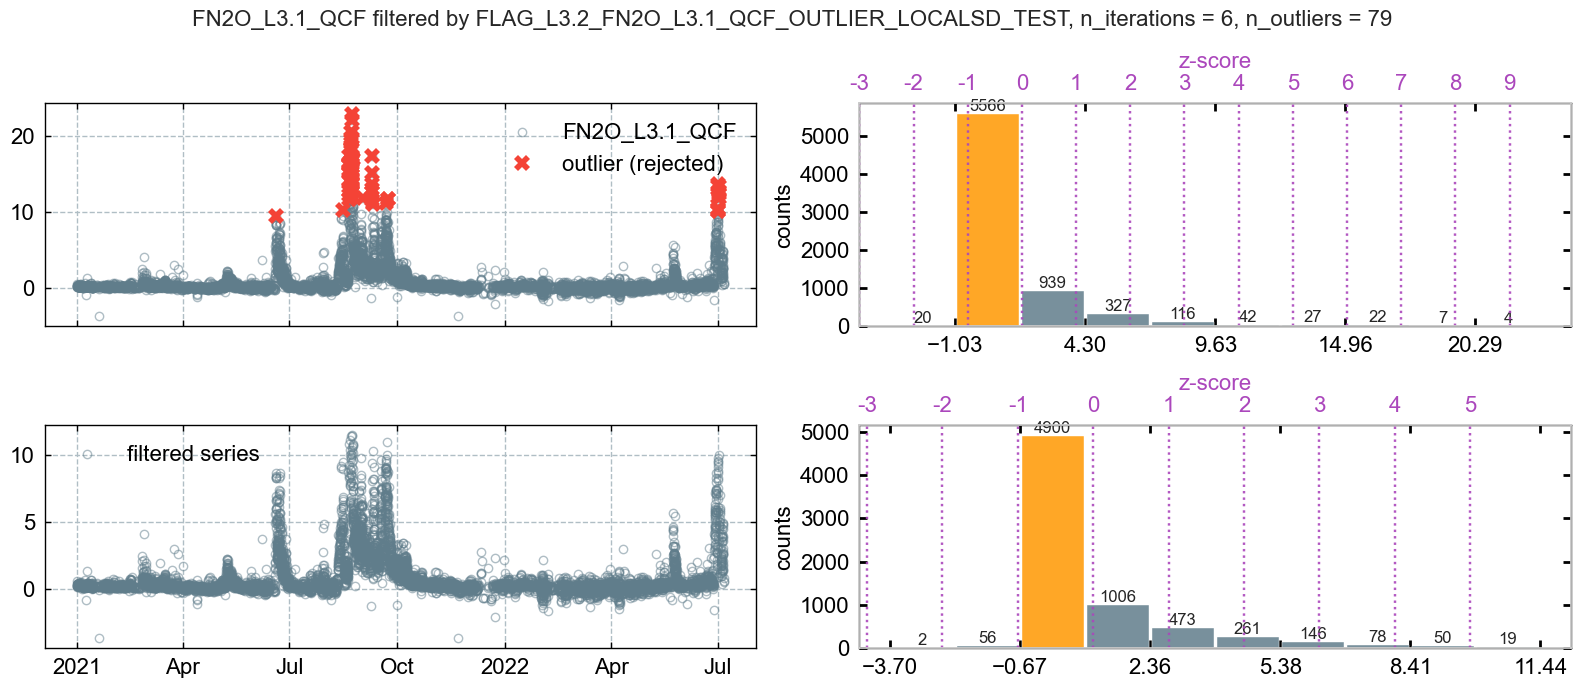

In [69]:
N_SD = 4.5
WINSIZE = 48 * 7
fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Increments z-score**

In [ ]:
# from diive.pkgs.outlierdetection.incremental import zScoreIncrements
# help(zScoreIncrements)

[zScoreIncrements]  running zScoreIncrements ...
[zScore]  running zScore ...
[zScore]  running zScore ...
[zScore]  running zScore ...
ITERATION#1: Total found outliers: 8 values (daytime+nighttime)
[zScore]  running zScore ...
[zScore]  running zScore ...
[zScore]  running zScore ...
ITERATION#2: Total found outliers: 2 values (daytime+nighttime)
[zScore]  running zScore ...
[zScore]  running zScore ...
[zScore]  running zScore ...
ITERATION#3: Total found outliers: 0 values (daytime+nighttime)


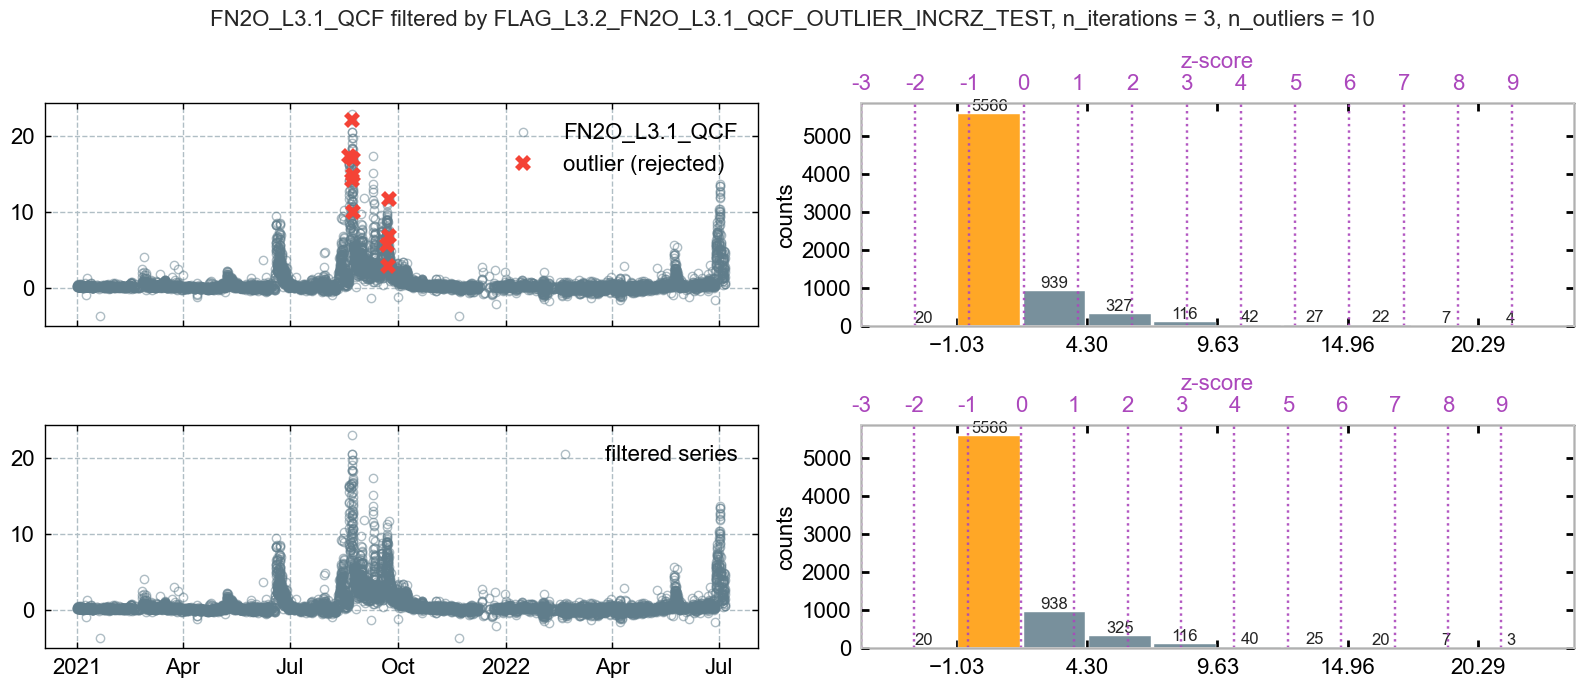

In [70]:
THRES_ZSCORE = 4
fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**, daytime/nighttime
- Test is run separately for daytime and nighttime data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
# help(LocalOutlierFactorDaytimeNighttime)

[LocalOutlierFactorDaytimeNighttime]  running LocalOutlierFactorDaytimeNighttime ...
ITERATION#1
Total found outliers: 35 values (daytime)
Total found outliers: 71 values (nighttime)
Total found outliers: 106 values (daytime+nighttime)


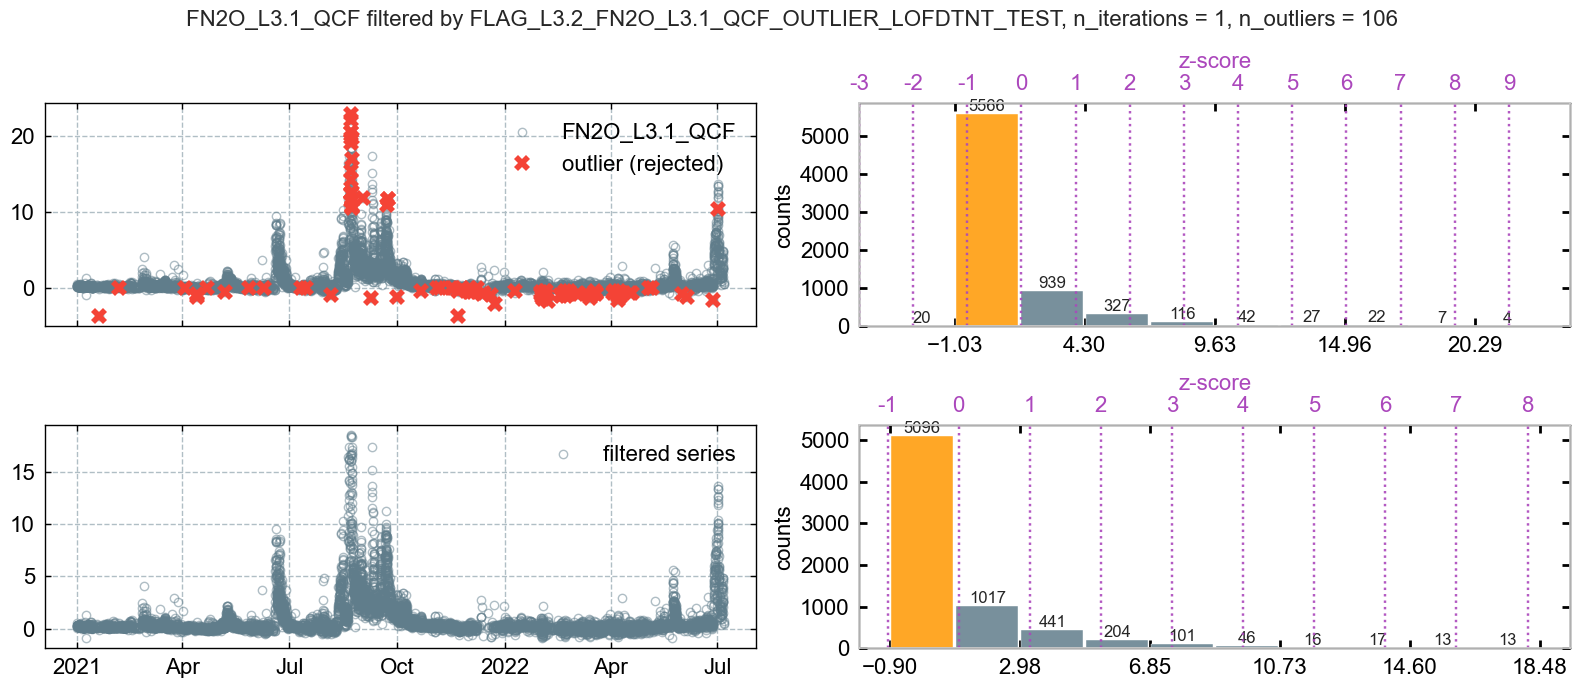

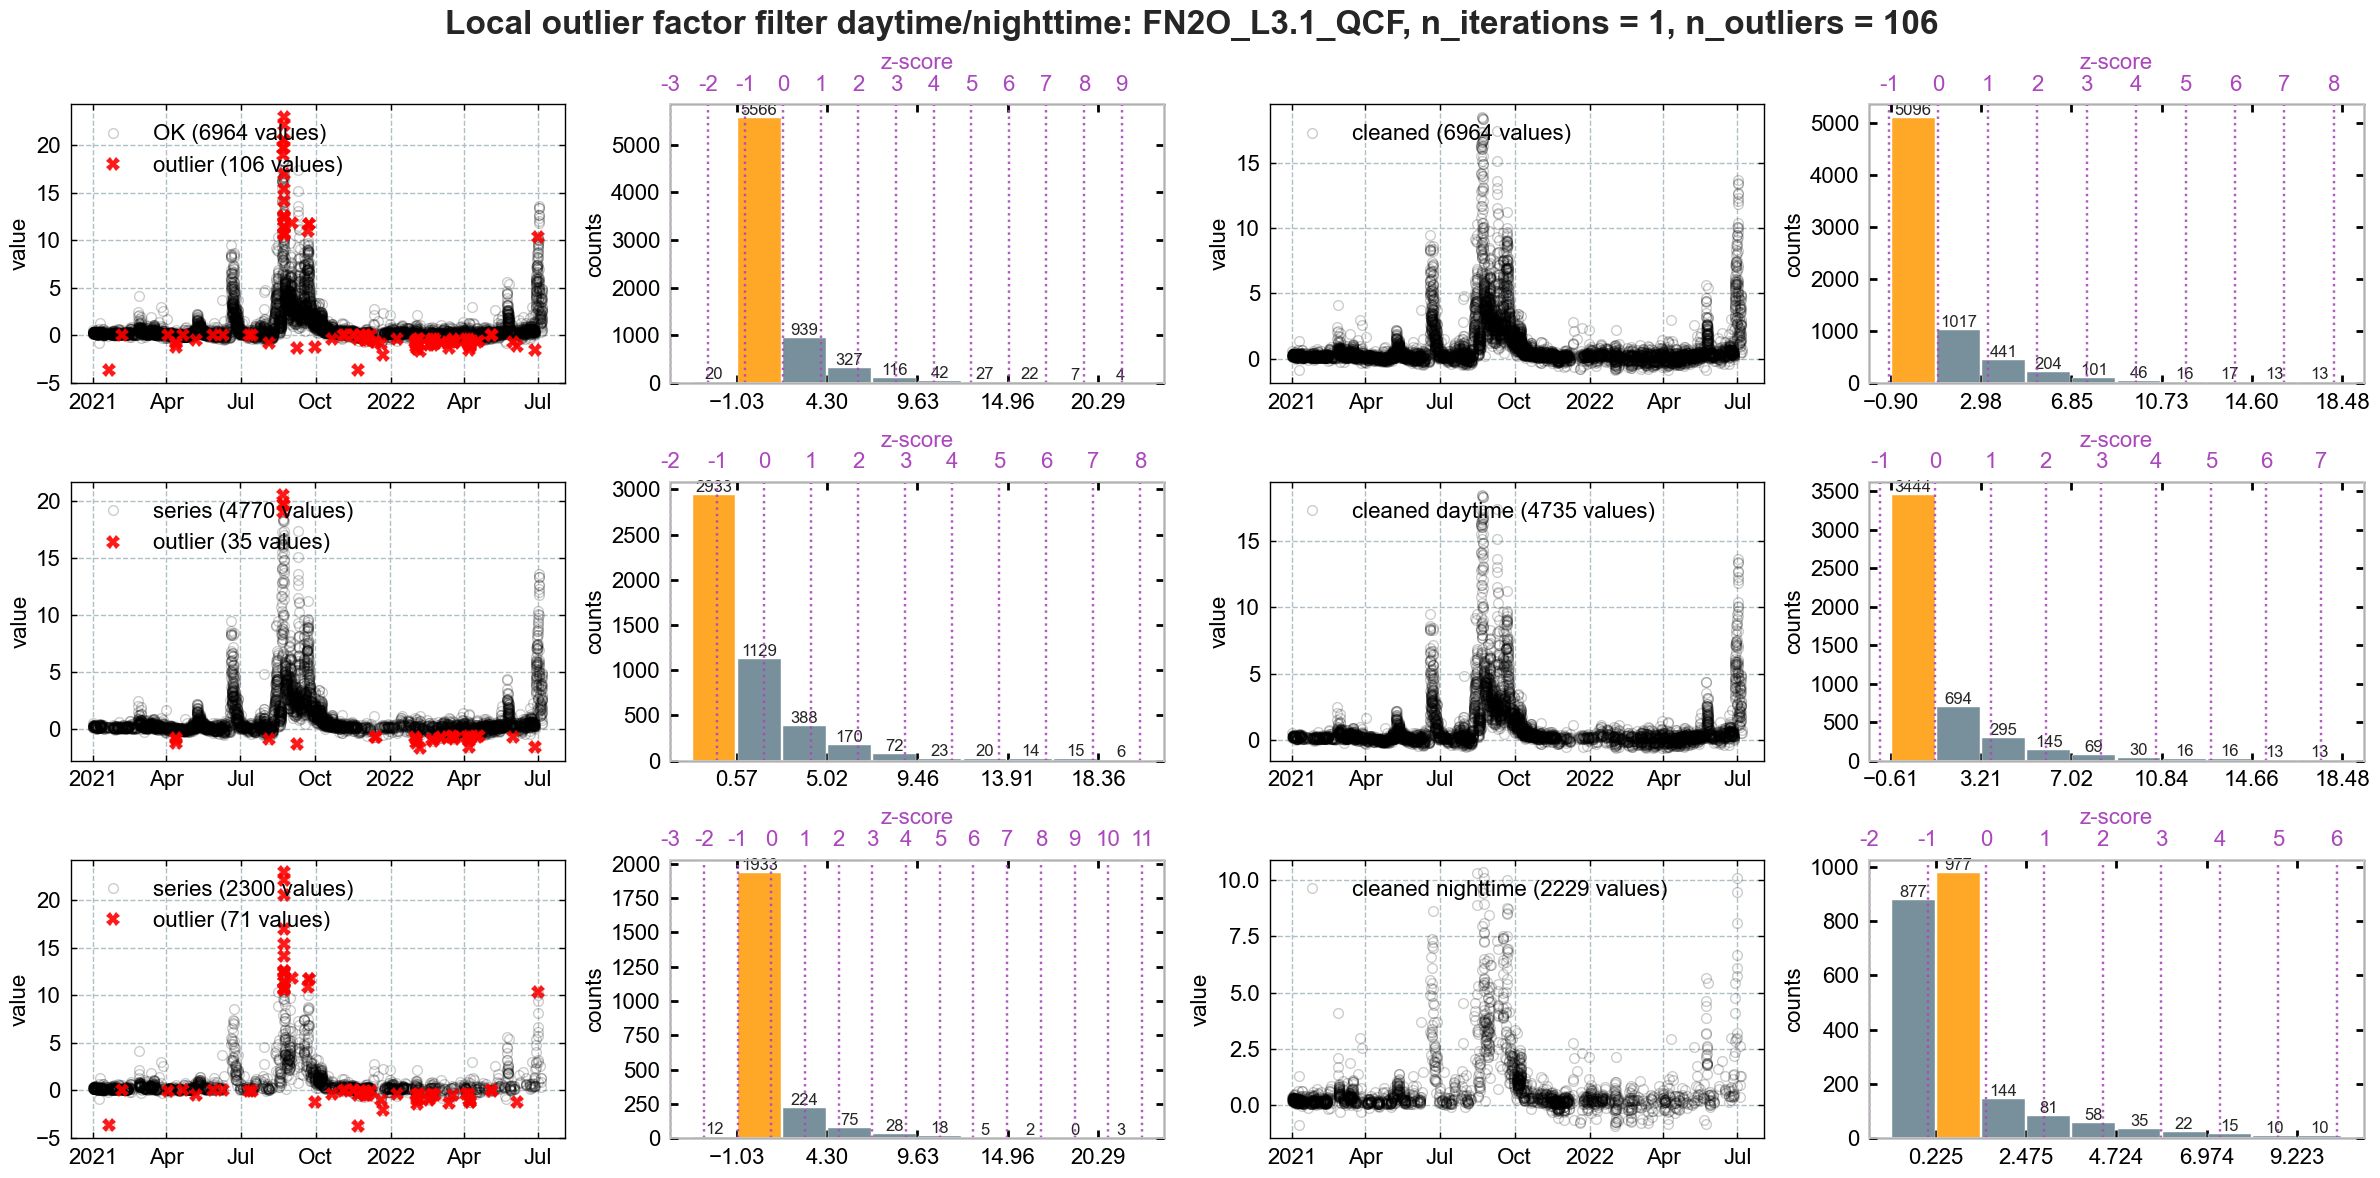

In [75]:
N_NEIGHBORS = 60
CONTAMINATION = None
fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**
- Test is run across all data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
# help(LocalOutlierFactorAllData)

[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 15 values (daytime+nighttime)


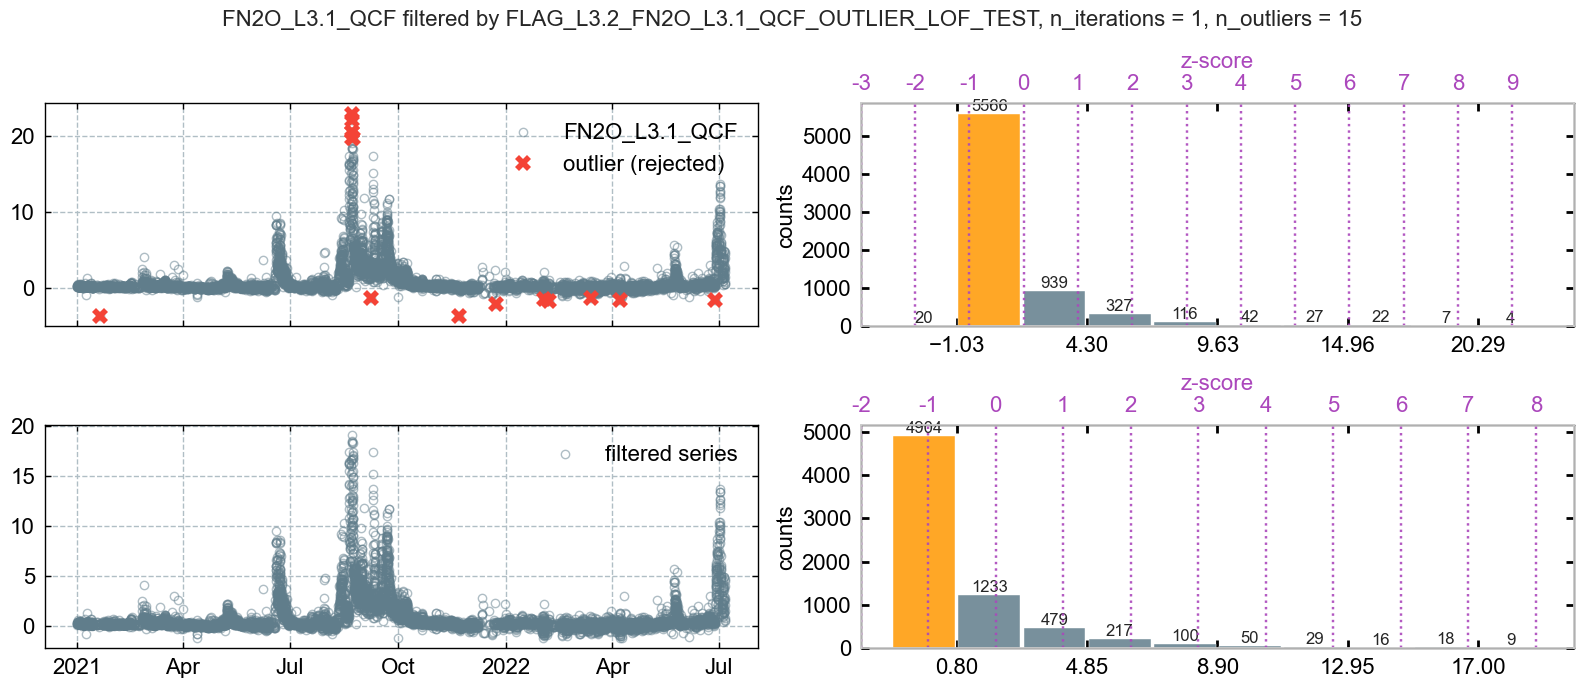

In [80]:
N_NEIGHBORS = 20
CONTAMINATION = None
fpc.level32_flag_outliers_lof_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Absolute limits**, separate for daytime and nighttime data

In [ ]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
# help(AbsoluteLimitsDaytimeNighttime)

In [ ]:
# MIN_DT = -50
# MAX_DT = 50
# MIN_NT = -25
# MAX_NT = 25
# fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Trim nighttime flux data**

In [ ]:
# from diive.pkgs.outlierdetection.trim import TrimLow
# help(TrimLow)

In [ ]:
# fpc.level32_flag_outliers_trim_low_test(trim_nighttime=True, lower_limit=-5, showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## **Finalize Level-3.2**: Calculate overall quality flag (so far)

In [83]:
fpc.finalize_level32(nighttime_threshold=50, daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)

++Added new column FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_HAMPEL_TEST.
++Added new column SUM_L3.2_FN2O_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_FN2O_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_FN2O_L3.1_FLAGS.
++Added new column FLAG_L3.2_FN2O_L3.1_QCF.
++Added new column FN2O_L3.1_L3.2_QCF.
++Added new column FN2O_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [84]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_HAMPEL_TEST',
 'SUM_L3.2_FN2O_L3.1_HARDFLAGS',
 'SUM_L3.2_FN2O_L3.1_SOFTFLAGS',
 'SUM_L3.2_FN2O_L3.1_FLAGS',
 'FLAG_L3.2_FN2O_L3.1_QCF',
 'FN2O_L3.1_L3.2_QCF',
 'FN2O_L3.1_L3.2_QCF0']

</br>

### Plot filtered flux after Level-3.2
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal
- flux after Level-3.2, after outlier removal
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

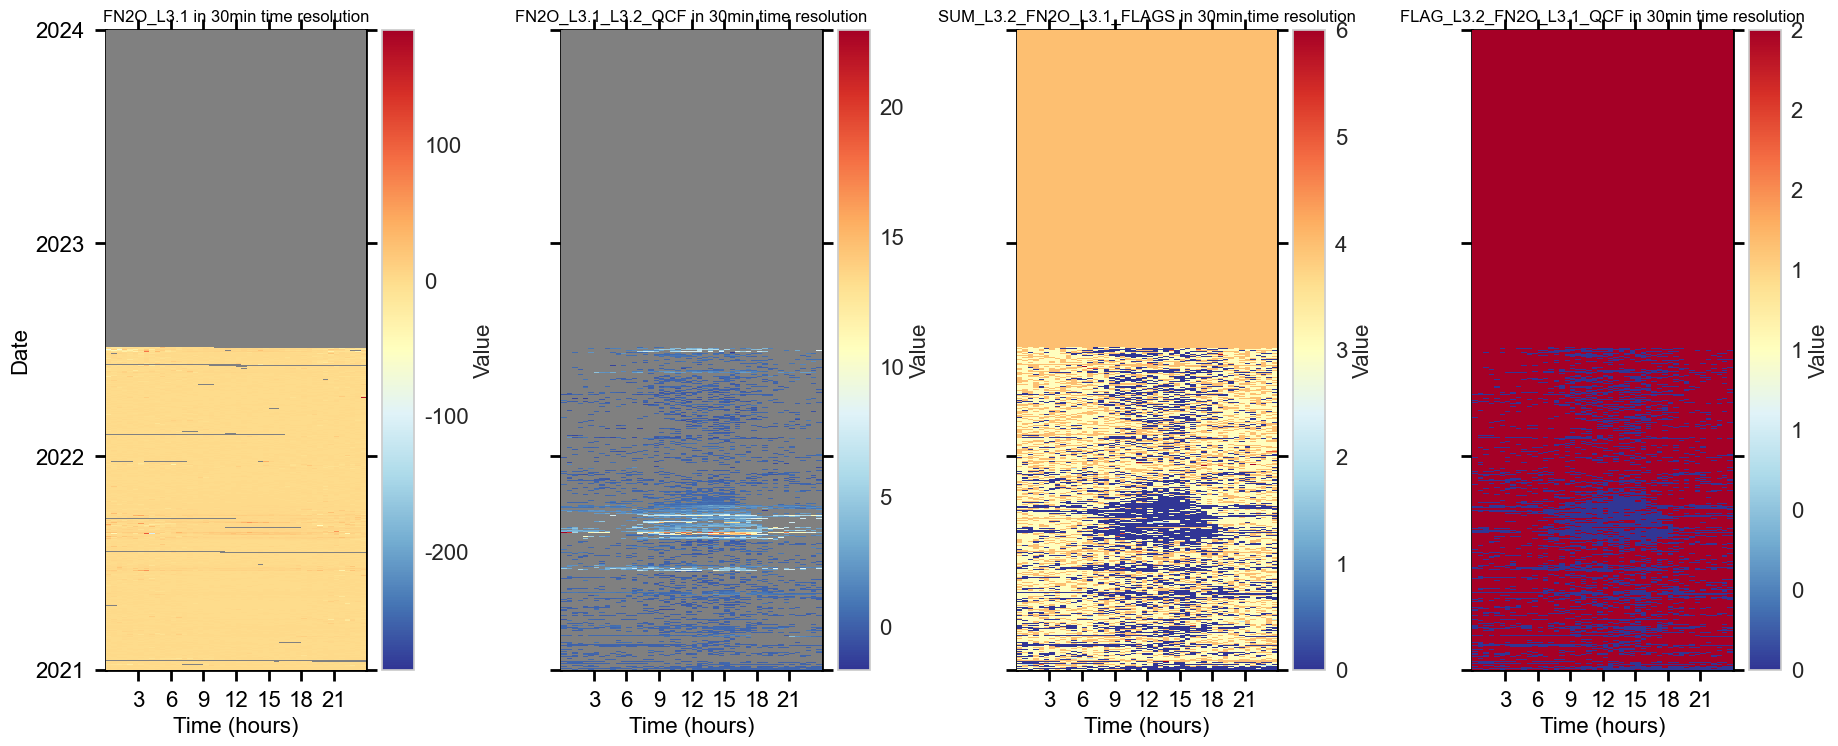

In [85]:
fpc.level32_qcf.showplot_qcf_heatmaps()

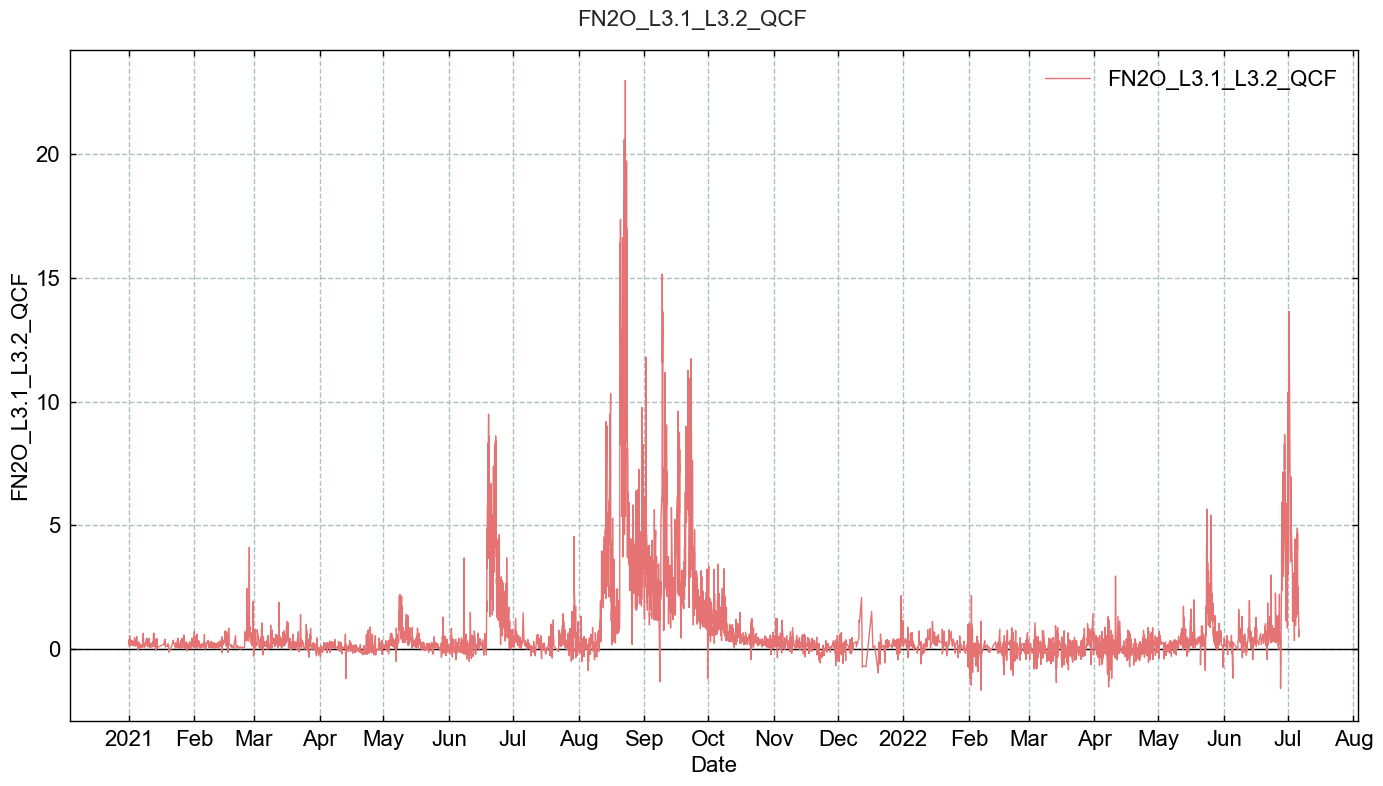

In [86]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [87]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [88]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FN2O_L3.1.

Number of FN2O_L3.1 records before QC: 25956
+++ FLAG_L2_FN2O_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 25956 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_SSITC_TEST rejected 6437 values (+24.80%)      TOTALS: flag 0: 7090 (27.32%) / flag 1: 12429 (47.88%) / flag 2: 6437 (24.80%)
+++ FLAG_L2_FN2O_COMPLETENESS_TEST rejected 26 values (+0.10%)      TOTALS: flag 0: 7080 (27.28%) / flag 1: 12413 (47.82%) / flag 2: 6463 (24.90%)
+++ FLAG_L2_FN2O_SCF_TEST rejected 4 values (+0.02%)      TOTALS: flag 0: 7078 (27.27%) / flag 1: 12411 (47.82%) / flag 2: 6467 (24.92%)
+++ FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 7078 (27.27%) / flag 1: 12411 (47.82%) / flag 2: 6467 (24.92%)
+++ FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 70

In [89]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_FN2O_L3.1_QCF, QCF FLAG FOR FN2O_L3.1
Between 2021-01-01 00:15 and 2023-12-31 23:45 ...
    Total flux records BEFORE quality checks: 25956 (49.38% of potential)
    Available flux records AFTER quality checks: 7057 (27.19% of total)
    Rejected flux records: 18899 (72.81% of total)
    Potential flux records: 52560
    Potential flux records missed: 26604 (50.62% of potential)



In [90]:
fpc.level32_qcf.report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FN2O_MISSING_TEST:
    OVERALL flag 0.0: 25956 values (49.38%)  
    OVERALL flag 2.0: 26604 values (50.62%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 12639 values (50.00%)  
    DAYTIME flag 2.0: 12639 values (50.00%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 13317 values (48.81%)  
    NIGHTTIME flag 2.0: 13965 values (51.19%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FN2O_SSITC_TEST:
    OVERALL flag 0.0: 7090 values (13.49%)  
    OVERALL flag 1.0: 12429 values (23.65%)  
    OVERALL flag 2.0: 6437 values (12.25%)  
    OVERALL flag missing: 26604 values (50.62%)  

    DAYTIME flag 0.0: 4780 values (18.91%)  
    DAYTIME flag 1.0: 5068 values (20.05%)  
    DAYTIME flag 2.0: 2791 values (11.04%)  
    DAYTIME flag missing: 12639 values (50.00%)  

    NIGHTTIME flag 0.0: 2310 values (8.47%)  
    NIGHTTIME flag 1.0: 7361 val

</br>

</br>

# Level-3.3: **USTAR FILTERING**
- Daytime and nighttime data are filtered based on USTAR thresholds

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



In [91]:
USTAR_SCENARIOS = ['CUT_16', 'CUT_50', 'CUT_84']
USTAR_THRESHOLDS = [0.0532449, 0.0709217, 0.0949867]
fpc.level33_constant_ustar(thresholds=USTAR_THRESHOLDS,
                           threshold_labels=USTAR_SCENARIOS,
                           showplot=False)

[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_16 0.0532449: 7732 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_50 0.0709217: 13546 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_84 0.0949867: 20953 values


## **Finalize Level-3.3**

In [92]:
# Finalize: stores results for each USTAR scenario in a dict
fpc.finalize_level33(nighttime_threshold=50, daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
                     nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW)

Calculating overall quality flag QCF for USTAR scenario CUT_16...
++Added new column FLAG_L3.3_CUT_16_FN2O_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT_16_FN2O_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT_16_FN2O_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT_16_FN2O_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT_16_FN2O_L3.1_QCF.
++Added new column FN2O_L3.1_L3.3_CUT_16_QCF.
++Added new column FN2O_L3.1_L3.3_CUT_16_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT_50...
++Added new column FLAG_L3.3_CUT_50_FN2O_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT_50_FN2O_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT_50_FN2O_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT_50_FN2O_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT_50_FN2O_L3.1_QCF.
++Added new column FN2O_L3.1_L3.3_CUT_50_QCF.
++Added new column FN2O_L3.1_L3.3_CUT_50_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT_84...
++Added new column FLAG_L3.3_CUT_84_FN2O_L3.1_USTAR_TEST.
++Added new 

</br>

# Add results to main data
- At this point, all flux processing results are stored in the `fpc` instance
- To be more specific, results are stored in a dataframe named `fpc_df` inside the `fpc` instance
- Here we combine the results from the flux processing chain with the original input dataframe 

First, let's get the results from the flux processing chain:

In [93]:
print("Getting results from the flux processing chain...")
results_flux_processing_chain = fpc.fpc_df.copy()
results_flux_processing_chain.describe()

Getting results from the flux processing chain...


FN2O         USTAR     SW_IN_POT       DAYTIME     NIGHTTIME  FLAG_L2_FN2O_MISSING_TEST  FLAG_L2_FN2O_SSITC_TEST  FLAG_L2_FN2O_COMPLETENESS_TEST  FLAG_L2_FN2O_SCF_TEST  FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST  FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST  FLAG_L2_FN2O_VM97_AOA_HF_TEST  SUM_L2_FN2O_HARDFLAGS  SUM_L2_FN2O_SOFTFLAGS  SUM_L2_FN2O_FLAGS  FLAG_L2_FN2O_QCF  FN2O_L2_QCF  FN2O_L2_QCF0   SN2O_SINGLE  SN2O_SINGLE_gfRF_L3.1  FLAG_SN2O_SINGLE_gfRF_ISFILLED_L3.1     FN2O_L3.1  FN2O_L3.1_QCF  FN2O_L3.1_QCF0  FLAG_L3.2_FN2O_L3.1_QCF_OUTLIER_ABSLIM_TEST  ...  SUM_L3.2_FN2O_L3.1_FLAGS  FLAG_L3.2_FN2O_L3.1_QCF  FN2O_L3.1_L3.2_QCF  FN2O_L3.1_L3.2_QCF0  FLAG_L3.3_CUT_16_FN2O_L3.1_USTAR_TEST  SUM_L3.3_CUT_16_FN2O_L3.1_HARDFLAGS  SUM_L3.3_CUT_16_FN2O_L3.1_SOFTFLAGS  SUM_L3.3_CUT_16_FN2O_L3.1_FLAGS  FLAG_L3.3_CUT_16_FN2O_L3.1_QCF  FN2O_L3.1_L3.3_CUT_16_QCF  FN2O_L3.1_L3.3_CUT_16_QCF0  FLAG_L3.3_CUT_50_FN2O_L3.1_USTAR_TEST  SUM_L3.3_CUT_50_FN2O_L3.1_HARDFLAGS  \
count  25956.000000  52198.000000  52560.000000  52560.000000  52560.000000               52560.000000             25956.000000                    25956.000000           25956.000000                              26181.0                             26181.0                            0.0           52560.000000           52560.000000       52560.000000      52560.000000  7078.000000   7078.000000  25917.000000           52560.000000                         52560.000000  25956.000000    7078.000000     7078.000000                                 52560.000000  ...              52560.000000             52560.000000         7057.000000          7057.000000                           52560.000000                         52560.000000                         52560.000000                     52560.000000                    52560.000000                6491.000000                 6491.000000                           52560.000000                         52560.000000   
mean       0.591538      0.148798    297.125361      0.480936      0.519064                   1.012329                 0.974842                        0.002620               0.001464                                  0.0                                 0.0                            NaN               1.258714               0.237043           1.495757          1.730670     1.207334      1.207334      0.000263              -0.013312                             0.506906      0.591798       1.192835        1.192835                                     0.000304  ...                  3.227226                 1.731469            1.179996             1.179996                               0.294216                             5.015868                             0.237043                         5.252911                        1.753006                   1.184619                    1.184619                               0.515449                             7.284323   
std        4.299590      0.142805    385.285444      0.499641      0.499641                   0.999934                 0.721483                        0.070723               0.044736                                  0.0                                 0.0                            NaN               0.966593               0.426033           0.722143          0.682738     2.474757      2.474757      0.533157               0.382217                             0.499957      4.267418       2.467345        2.467345                                     0.024673  ...                  1.337828                 0.681881            2.263789             2.263789                               0.708434                             2.180477                             0.426033                         2.156552                        0.658020                   2.298650                    2.298650                               0.874771                             3.117733   
min     -306.444000      0.006538      0.000000      0.000000      0.000000                   0.000000                 0.000000        

Now check for new columns that are not in the original input data:

In [94]:
newcols = [c for c in results_flux_processing_chain.columns if c not in maindf.columns]
print(f"Currently the original input dataframe has {len(maindf.columns)} variables.")
print(
    f"The flux processing chain dataframe with new results has {len(results_flux_processing_chain.columns)} variables for flux {FLUXVAR}.")
print(f"In total, {len(newcols)} new variables will be added back to the main data.")
print(f"New columns generated in the flux processing chain:\n{'-' * 20}")
[print(f"   --> Found new variable {col} in flux processing chain results.") for col in newcols];

Currently the original input dataframe has 438 variables.
The flux processing chain dataframe with new results has 53 variables for flux FN2O.
In total, 49 new variables will be added back to the main data.
New columns generated in the flux processing chain:
--------------------
   --> Found new variable DAYTIME in flux processing chain results.
   --> Found new variable NIGHTTIME in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_MISSING_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_SSITC_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_COMPLETENESS_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_SCF_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST in flux processing chain results.
   --> Found new variable FLAG_L2_FN2O_VM97_AOA_

Now it's time to add the new columns to the original input data:

In [95]:
maindf2 = maindf.copy()  # Make a copy so we can restart this step directly from here, in case something goes wrong further down, better safe than sorry
maindf2 = pd.concat([maindf2, results_flux_processing_chain[newcols]], axis=1)
print(f"New variables were added to main data.")
print(f"The main dataframe now has {len(maindf2.columns)} variables.")


New variables were added to main data.
The main dataframe now has 487 variables.


</br>

</br>

# Overview: data after `Level-3.3`

## Flux variable names

In [96]:
fluxes_qcf = [c for c in maindf2.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.3" in c]
fluxes_qcf0 = [c for c in maindf2.columns if
               str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.3" in c]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

Quality-controlled fluxes: ['FN2O_L3.1_L3.3_CUT_16_QCF', 'FN2O_L3.1_L3.3_CUT_50_QCF', 'FN2O_L3.1_L3.3_CUT_84_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['FN2O_L3.1_L3.3_CUT_16_QCF0', 'FN2O_L3.1_L3.3_CUT_50_QCF0', 'FN2O_L3.1_L3.3_CUT_84_QCF0']
****************************************************************************************************
Note that since only QCF below 1 is accepted for daytime and nighttime data, the _QCF and _QCF0 variables are identical.


</br>

In [97]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"
FLUXVAR33QCF = fpc.filteredseries_level33_qcf

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print(
    f""
    f"{FLUXVAR} ... original input flux\n"
    f"{FLUXVAR2QCF} ... flux quality-controlled with Level-2 flags\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR31QCF} ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction\n   -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF} ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF_HQ} ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
)
print("Variables for further steps:")
for key, value in FLUXVAR33QCF.items():
    print(
        f"{FLUXVAR33QCF[key].name} ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering ({key}), including Level-3.1 storage correction\n-->   to be used in gap-filling and all further steps")

if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------
FN2O ... original input flux
FN2O_L2_QCF ... flux quality-controlled with Level-2 flags
    -->  not used in any further processing steps
FN2O_L3.1_QCF ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction
   -->  not used in any further processing steps
FN2O_L3.1_L3.2_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps
FN2O_L3.1_L3.2_QCF0 ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps

Variables for further steps:
FN2O_L3.1_L3.3_CUT_16_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering (CUT_16), including Level-3.1 storage correction
-->   to be used in gap-filling and all further steps
FN2O_L

</br>

</br>

## Plot quality-controlled flux after `Level-3.3`
- Plot flux after storage-correction, flux quality control, outlier removal and USTAR filtering

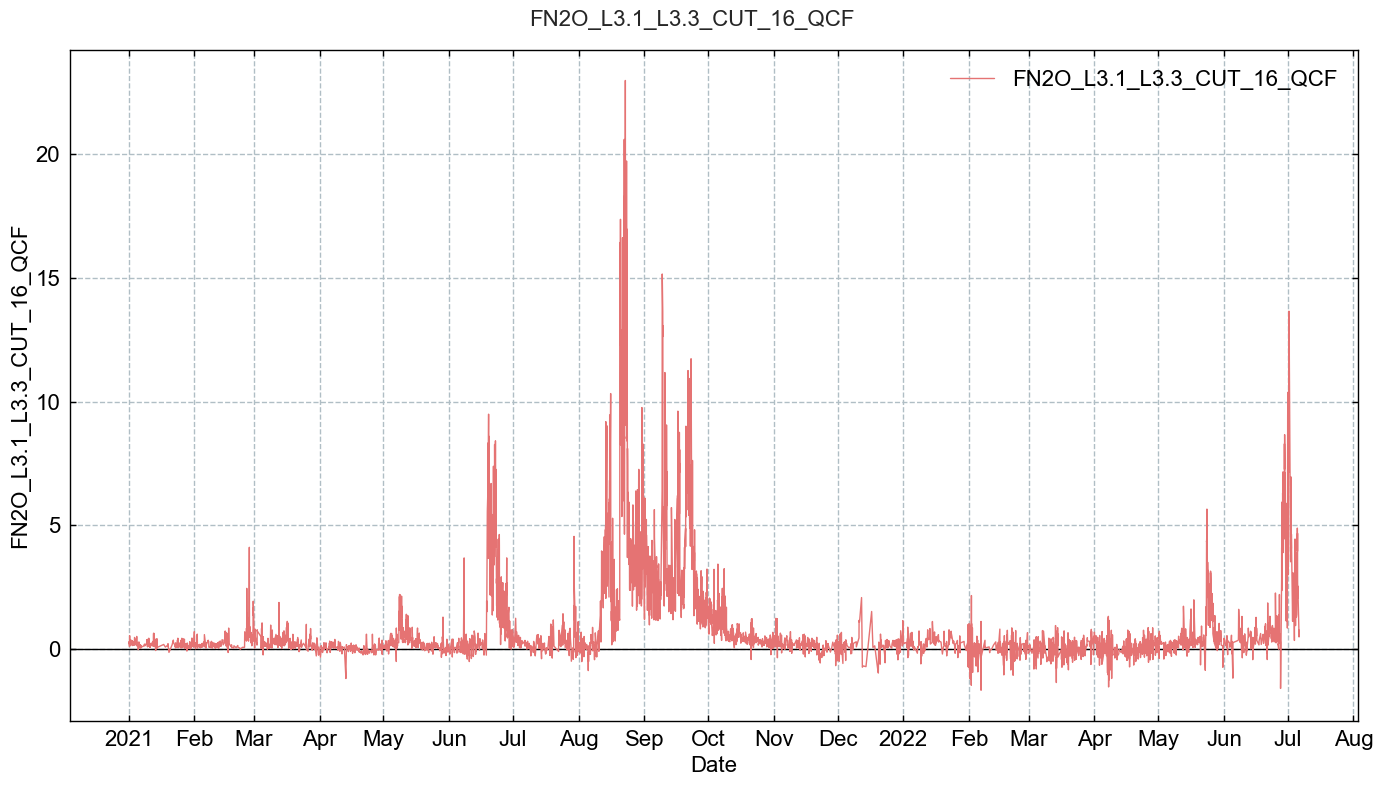

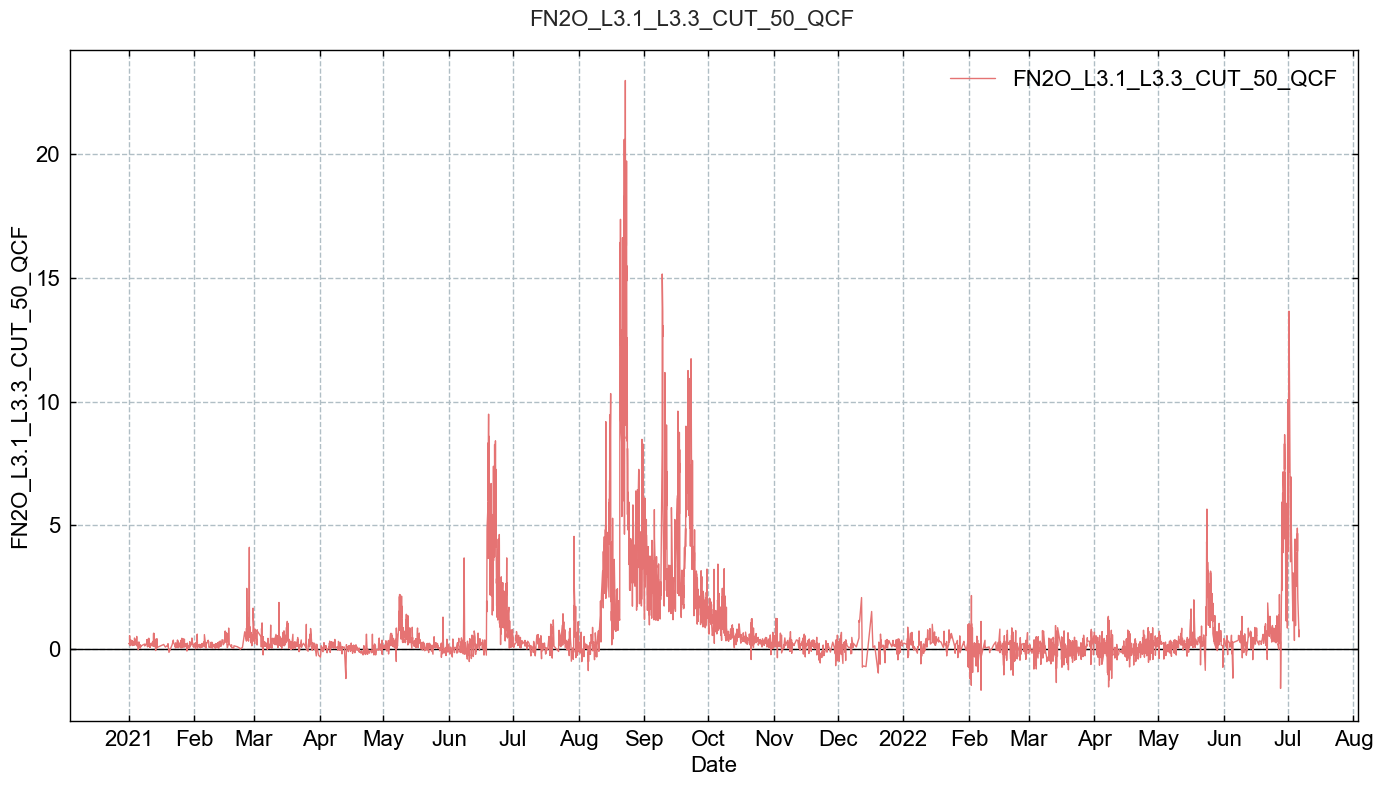

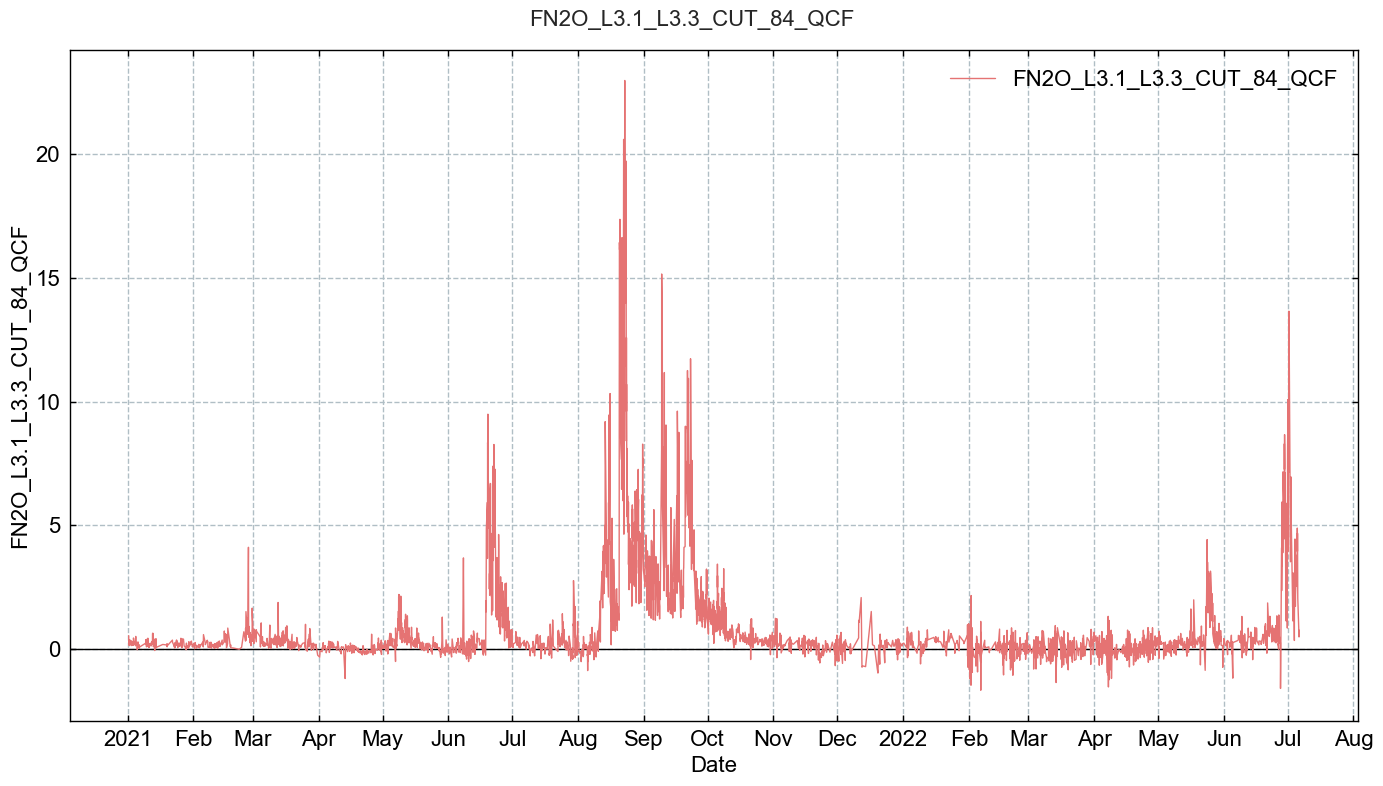

In [98]:
for key, value in FLUXVAR33QCF.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    TimeSeries(series=maindf2[FLUXVAR33QCF[key].name]).plot()

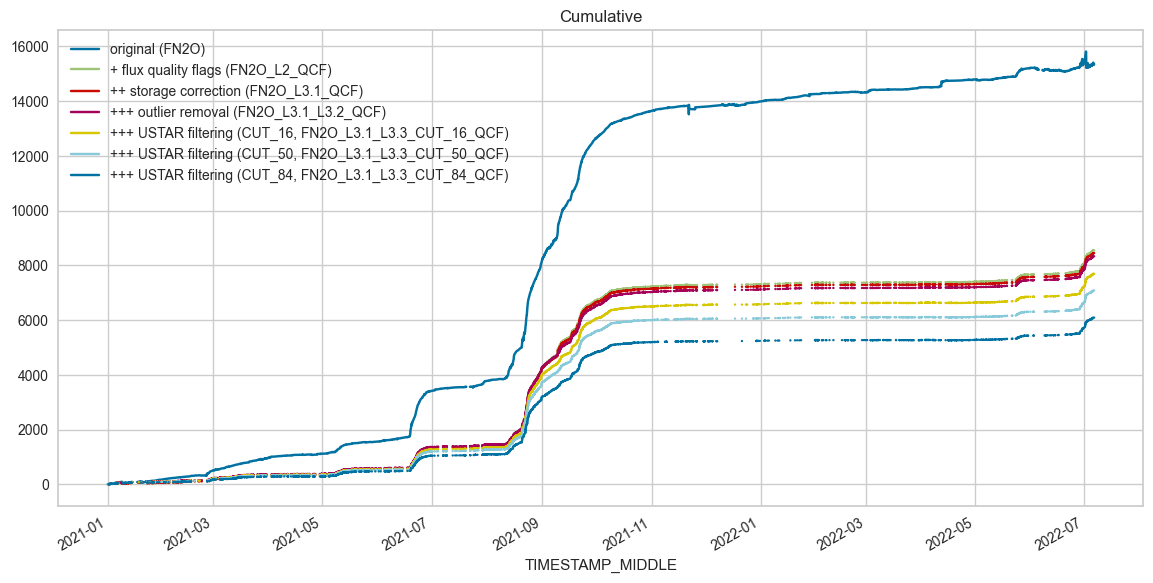

In [99]:
# Creating a dictionary by passing Series objects as values

frame = {
    f'original ({FLUXVAR})': maindf2[FLUXVAR],
    f'+ flux quality flags ({FLUXVAR2QCF})': maindf2[FLUXVAR2QCF],
    f'++ storage correction ({FLUXVAR31QCF})': maindf2[FLUXVAR31QCF],
    f'+++ outlier removal ({FLUXVAR32QCF})': maindf2[FLUXVAR32QCF]
}
for key, value in FLUXVAR33QCF.items():
    frame[f'+++ USTAR filtering ({key}, {FLUXVAR33QCF[key].name})'] = FLUXVAR33QCF[key]

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(14, 7), x_compat=True, alpha=1);

</br>

## Comparison flux quality

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))


FN2O_L3.1_L3.2_QCF0  FN2O_L3.1_L3.2_QCF1
count          7057.000000                  0.0
mean              1.179996                  NaN
std               2.263789                  NaN
min              -1.652174                  NaN
25%               0.133497                  NaN
50%               0.321245                  NaN
75%               1.205961                  NaN
max              22.958631                  NaN

****************************************************************************************************
Note that since only QCF below 1 is accepted for daytime and nighttime data, there are only high-quality (QCF=QCF0) data in the dataset (i.e., no medium quality QCF1).


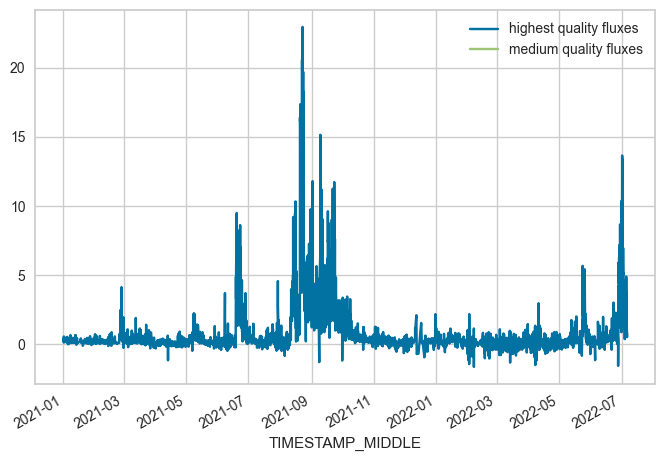

In [100]:
MQ = fpc.level32_qcf.flagqcf == 1
highest_quality = maindf2[FLUXVAR32QCF_HQ].copy().dropna()
medium_quality = maindf2[FLUXVAR32QCF][MQ].copy().dropna()
medium_quality.name = f"{medium_quality.name}1"
print(scipy.stats.ttest_ind(a=highest_quality.to_numpy(), b=medium_quality.to_numpy(), equal_var=True))
ab = {'highest quality fluxes': highest_quality, 'medium quality fluxes': medium_quality}
pd.DataFrame.from_dict(ab).plot(x_compat=True);
display(pd.concat([highest_quality.describe(), medium_quality.describe()], axis=1))
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"there are only high-quality (QCF=QCF0) data in the dataset (i.e., no medium quality QCF1).")

</br>

## Available `Level-3.3` fluxes

In [101]:
_fluxcols = [x for x in maindf2.columns if
             'L3.1' and 'L3.3' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
_fluxcols

['FN2O_L3.1_L3.3_CUT_16_QCF',
 'FN2O_L3.1_L3.3_CUT_50_QCF',
 'FN2O_L3.1_L3.3_CUT_84_QCF']

In [102]:
_subset = maindf2[_fluxcols].copy()
_subset.head()

FN2O_L3.1_L3.3_CUT_16_QCF  FN2O_L3.1_L3.3_CUT_50_QCF  FN2O_L3.1_L3.3_CUT_84_QCF
TIMESTAMP_MIDDLE                                                                                    
2021-01-01 00:15:00                        NaN                        NaN                        NaN
2021-01-01 00:45:00                        NaN                        NaN                        NaN
2021-01-01 01:15:00                   0.229798                   0.229798                        NaN
2021-01-01 01:45:00                        NaN                        NaN                        NaN
2021-01-01 02:15:00                        NaN                        NaN                        NaN

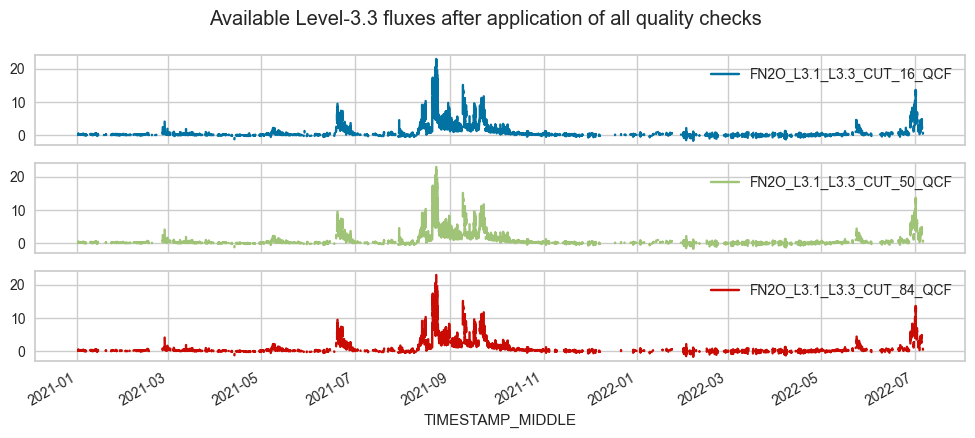

In [103]:
_subset.plot(subplots=True, x_compat=True,
             title="Available Level-3.3 fluxes after application of all quality checks", figsize=(12, 4.5));

In [104]:
maindf2

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD      BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_HEIGHT_SA  BADM_SA_OFFSET_NORTH  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_H2O  BADM_INSTPAIR_EASTWARD_SEP_GA_H2O  BADM_INSTPAIR_HEIGHT_SEP_GA_H2O  CUSTOM_FILTER_NR   CO2_NR  CO2_MEAS_TYPE  ...  SUM_L3.2_FN2O_L3.1_FLAGS  FLAG_L3.2_FN2O_L3.1_QCF  FN2O_L3.1_L3.2_QCF  FN2O_L3.1_L3.2_QCF0  FLAG_L3.3_CUT_16_FN2O_L3.1_USTAR_TEST  SUM_L3.3_CUT_16_FN2O_L3.1_HARDFLAGS  SUM_L3.3_CUT_16_FN2O_L3.1_SOFTFLAGS  SUM_L3.3_CUT_16_FN2O_L3.1_FLAGS  FLAG_L3.3_CUT_16_FN2O_L3.1_QCF  FN2O_L3.1_L3.3_CUT_16_QCF  FN2O_L3.1_L3.3_CUT_16_QCF0  FLAG_L3.3_CUT_50_FN2O_L3.1_USTAR_TEST  SUM_L3.3_CUT_50_FN2O_L3.1_HARDFLAGS  SUM_L3.3_CUT_50_FN2O_L3.1_SOFTFLAGS  \
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2021-01-01 00:15:00  0.023716      1.21833     1228.85  1008.63         0.0                   1.0        NaN           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                 NaN                                NaN                              NaN           36000.0  36000.0            2.0  ...                       3.0                      2.0                 NaN                  NaN                                    0.0                                  4.0                                  1.0                              5.0                             2.0                        NaN                         NaN                                    2.0                                  8.0                                  1.0   
2021-01-01 00:45:00  0.023712      1.21856     1229.06  1008.62         0.0                   1.0  -0.253403           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                14.0                               31.0                              1.0           36000.0  35989.0            2.0  ...                       3.0                      2.0                 NaN                  NaN                                    0.0                                  4.0                                  1.0                              5.0                             2.0                        NaN                         NaN                                    0.0                                  6.0                                  1.0   
2021-01-01 01:15:00  0.023706      1.21884     1229.36  1008.63         0.0            

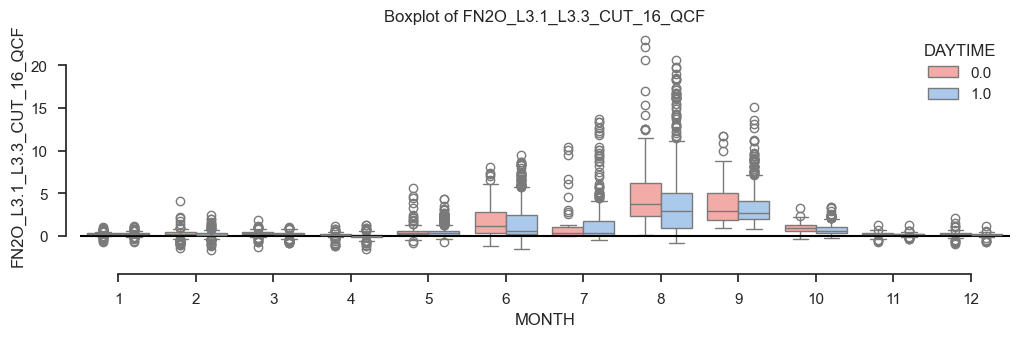

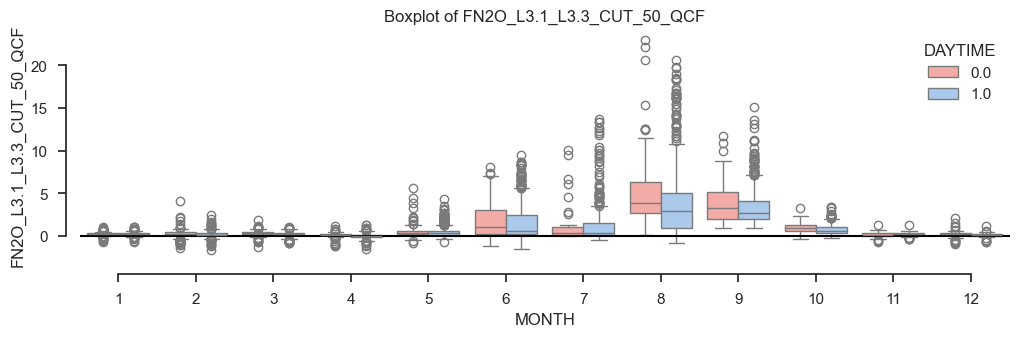

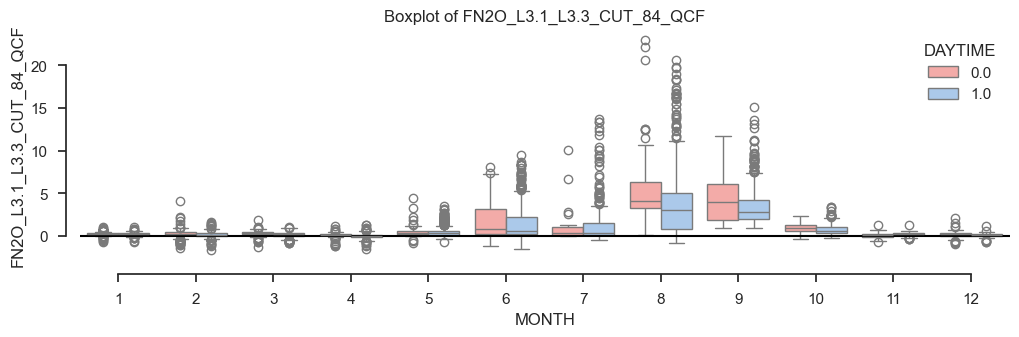

In [105]:
# Draw boxplots
for _f in _fluxcols:
    boxplots_df = maindf2[[_f, "DAYTIME"]].copy()
    boxplots_df["MONTH"] = boxplots_df.index.month
    sns.set_theme(style="ticks", palette="pastel")
    plt.figure(figsize=(12, 3))
    sns.boxplot(x="MONTH", y=_f, palette=["r", "b"], hue="DAYTIME", data=boxplots_df).set_title(f"Boxplot of {_f}")
    sns.despine(offset=10, trim=True)
    plt.axhline(0, color="black");

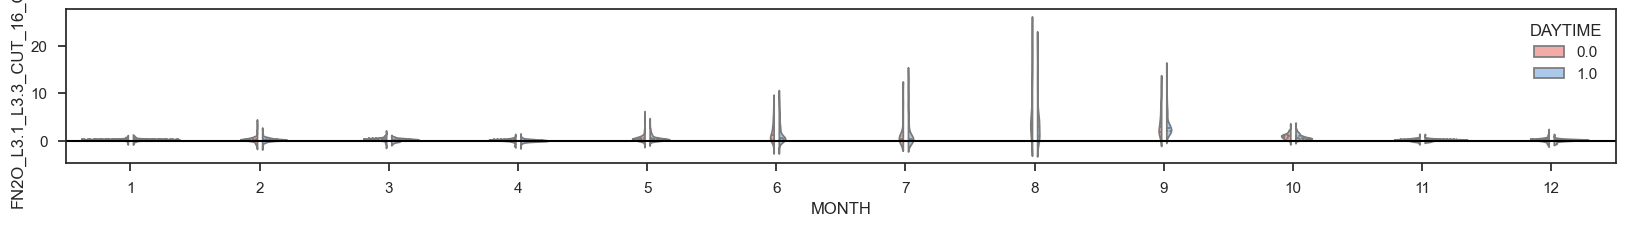

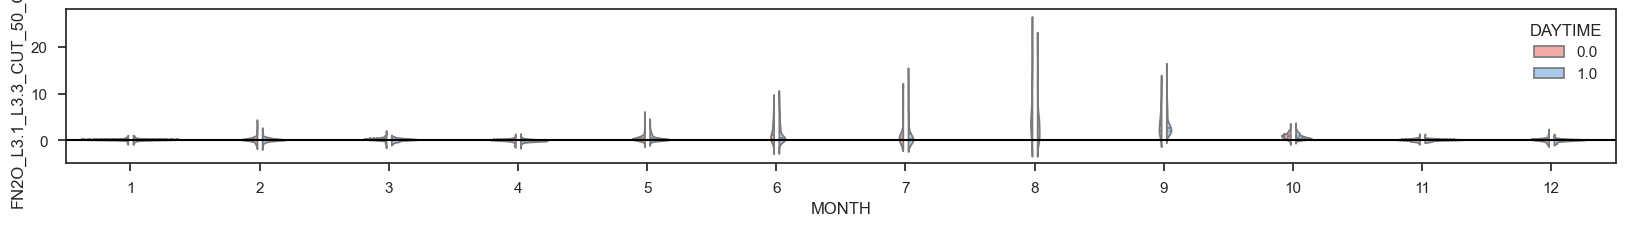

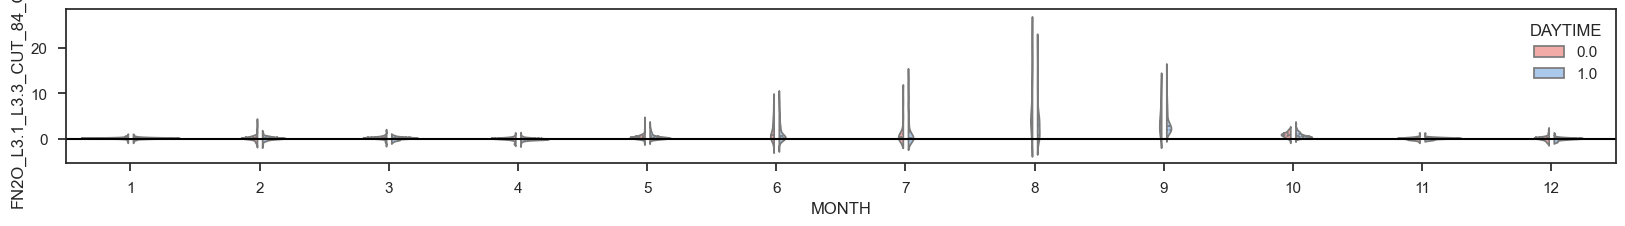

In [106]:
# Draw a nested violinplot and split the violins for easier comparison
for _f in _fluxcols:
    plt.figure(figsize=(20, 2))
    sns.violinplot(data=boxplots_df, x="MONTH", y=maindf2[_f], hue="DAYTIME", split=True, palette=["r", "b"], gap=.1,
                   inner="quart")
    plt.axhline(0, color="black")

</br>

</br>

# Save results to file
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

## Option 1: Save to CSV (large and slow)

In [ ]:
# maindf2.to_csv("FluxProcessingChain_L3.2.csv")

</br>

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [ ]:
save_parquet(data=maindf2, filename="FluxProcessingChain_L3.2")

</br>

## *(Preliminary) Impact of different USTAR thresholds on data availability*

In [ ]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios

ust = UstarThresholdConstantScenarios(series=maindf2[FLUXVAR32QCF],
                                      swinpot=maindf2['SW_IN_POT'],
                                      ustar=maindf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")